<img src="https://habrastorage.org/webt/3x/l-/yv/3xl-yvgopmrwrjaz7hvkouaplye.png" />

_Автор: Лопухова Арина (Slack: @erynn)_


## Содержание <a name="cont"></a>
1. [Описание задачи и данных](#intro)
2. [Создание признаков I](#feat_1)
3. [Первичный и визуальный анализ. Найденные зависимости](#analysis)
4. [Создание признаков II](#feat_2)
5. [Выбор моделей и метрики](#model)
6. [Предобработка данных, обучение, оценка результатов на LB](#learning)
    
    6.1 [KNeighborsRegressor](#knr)
    
    6.2 [KNeighborsRegressor на расширенной выборке](#knr)
    
    6.3 [RandomForestRegressor](#rfr)
    
    6.4 [XGBRegressor](#xgb)

7. [Почти выводы](#alm_conc)
8. [Выводы](#conc)

## Описание задачи и данных <a name="intro"></a>

[К началу](#cont)

Подробное описание задачи и данных можно посмотреть [на странице соревнования.](https://datasouls.com/c/mts-geohack/description) Задача в том, чтобы по среднему числу звонков в экстренные службы с участков примерно 500x500 метров в западной части Москвы и Московской области спрогнозировать число звонков с таких участков в восточной части Москвы и Московской области по каждому дню недели. Данные 2017 года.  

Качество оценивается через [коэффициент ранговой корреляции Кендалла](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D0%9A%D0%B5%D0%BD%D0%B4%D0%B5%D0%BB%D0%BB%D0%B0) независимо по каждому дню недели. 

Задача интересна тем, что потенциально может выявить проблемные районы, которым нужны изменения в инфраструктуре или больше внимания экстренных служб. Она также полезна как анализ нагрузки на сотового оператора (все-таки данные предоставляет МТС). Плюс задача хороша в учебно-исследовательском плане, потому что предполагает работу с геоданными, к тому же из внешних источников вроде [OpenStreetMap](https://www.openstreetmap.org/). Готовых признаков вообще по сути нет, и все нужно делать вручную. 

Данные (train + test в одном файле и все остальные дополнительные данные) можно скачать [отсюда](https://drive.google.com/file/d/10F166_vlWkP2-z526nTaiWG4efMyIf8a/view?usp=sharing).

Значения переменных:
* __lat_bl, lon_bl__ — координаты нижнего левого угла участка
* __lat_tr, lon_tr__ — координаты верхнего правого угла участка
* __lat_c, lon_c__ — координаты центра участка
* __calls_daily__ — среднее число вызовов по всем дням
* __calls_workday__ — среднее число вызовов по рабочим дням
* __calls_weekend__ — среднее число вызовов по выходным дням
* __calls_wd{D}__ — среднее число вызовов по дню недели D (0 — понедельник, 6 — воскресенье)
* __is_test__ — индикатор того, что объект тестовый (у тестовых объектов значения числа звонков не показаны)
* __is_target__ — индикатор целевого участка (указан только для обучающей выборки)

Про целевой участок: качество предсказания оценивается не по всей тестовой части, а только по тем участкам, которые входят в целевые. Участки из тестовой выборки отбираются в целевые по тому же принципу, что и участки обучающей (по какому — участникам неизвестно).

Целевой признак — __calls_wd{D}__.

__Примечание к работе:__ в [репозитории](https://github.com/datasouls/mts-geohack/blob/master/Geohack112_StarterKit.ipynb) соревнования есть базовая тетрадка Starter Kit, части которой здесь будут использоваться. Оттуда взяты идеи про расстояние до Кремля и близость к каким-то объектам/число объектов в радиусе (часть про конструирование признаков). Взятый из Kit код будет помечен как #SK.

__Установка osmread для работы с OpenStreetMap и импорт библиотек__

In [1]:
# !pip install osmread

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from scipy.stats import kendalltau
import osmread

from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import os

In [3]:
%matplotlib inline
#размер графиков
mpl.rcParams['figure.figsize'] = (8, 7)
#стиль и размер шрифта
sns.set(style='whitegrid', font_scale=1.5)

In [4]:
PATH_TO_DATA = './data/'  #путь к данным 

distance из cython_dist — реализованная на cython функция для подсчета расстояния в км между точками в географических координатах

In [5]:
from cython_dist import distance

__Считаем файл с участками__

In [6]:
zones_df = pd.read_csv('data/zones.csv', index_col='zone_id')
zones_df.head()

,lat_bl,lon_bl,lat_tr,lon_tr,lat_c,lon_c,is_test,is_target,calls_daily,calls_workday,calls_weekend,calls_wd0,calls_wd1,calls_wd2,calls_wd3,calls_wd4,calls_wd5,calls_wd6
zone_id,,,,,,,,,,,,,,,,,,
0,55.378220,36.999105,55.382744,37.007050,55.380482,37.003077,0,0.0,0.002177,0.001325,0.004213,0.003006,0.000000e+00,6.885802e-04,0.003006,0.000000e+00,0.001374,0.007052
1,55.378252,37.006994,55.382775,37.014938,55.380514,37.010966,0,0.0,0.000996,0.000535,0.002096,0.000765,0.000000e+00,1.176913e-03,0.000765,0.000000e+00,0.001374,0.002818
2,55.378284,37.014883,55.382806,37.022827,55.380545,37.018855,0,0.0,0.001284,0.000724,0.002622,0.001322,0.000000e+00,1.020885e-03,0.001322,0.000000e+00,0.001374,0.003871
3,55.378315,37.022772,55.382837,37.030715,55.380576,37.026744,0,0.0,0.000968,0.000476,0.002143,0.000815,0.000000e+00,7.802124e-04,0.000815,0.000000e+00,0.001374,0.002912
4,55.378345,37.030662,55.382867,37.038603,55.380606,37.034633,0,0.0,0.000842,0.000310,0.002113,0.000783,1.821651e-07,7.286604e-07,0.000782,8.602241e-07,0.001374,0.002851


__Считаем из tagged_nodes.pickle объекты из OSM__, которые попали в интересующий нас регион и имеют хотя бы один тег. Подробно о том, как шла работа с картой и создавался tagged_nodes.pickle, можно посмотреть в [Starter Kit](https://github.com/datasouls/mts-geohack/blob/master/Geohack112_StarterKit.ipynb), раздел "Работа с данными OpenStreetMap".  

Если вкратце про объекты карты OSM, то их три типа (описание из того же Starter Kit): 
* __Node__  — точки на карте
* __Way__  — дороги, площади, задающиеся набором точек
* __Relation__  — связи между элементами

В tagged_nodes.pickle только объекты типа Node, которые попали в большой прямоугольник от Наро-Фоминска на юго-западе от Москвы до Красноармейска на северо-востоке от Москвы.

In [7]:
with open(os.path.join(PATH_TO_DATA, 'tagged_nodes.pickle'), 'rb') as f:
    tagged_nodes = pickle.load(f)

__Пример объекта__

In [8]:
tagged_nodes[17]

Node(id=31447925, version=8, changeset=38761813, timestamp=1461256486, uid=3855856, tags={'esr:user': '181723', 'express:use': '2000275', 'name': 'Сетунь', 'railway': 'halt', 'wheelchair': 'no'}, lon=37.3974261, lat=55.7237247)

## Создание признаков I <a name="feat_1"></a>

[К началу](#cont)

С этого все начнется, потому что использовать готовые данные в виде чистых координат не имеет смысла. Уже после накидывания признаков будет проведен их анализ.

__Расстояние до Кремля__

Мотивация: районы ближе к центру воспринимаются как более благополучные по сравнению с окраинами, что должно влиять на количество звонков в полицию.

__Признаки вида: 1) число объектов какого-то типа в определенном радиусе от центра участка; 2) расстояние до k ближайших объектов какого-то типа; 3) расстояние от центра участка до ближайшего объекта определенного типа__

Под объектами имеются в виду объекты OpenStreetMap.

Мотивация:
* __Магазины__: 1) плотная застройка магазинами позволяет отделить более старые обжитые районы от новых микрорайонов с новостройками ближе к окраинам; 2) магазины — открытые многолюдные места, которые обеспечивают поток людей на ближайших улицах, что должно уменьшать вероятность преступлений на улице 
* __Рестораны, кафе + кино, театр + каток, площадка, парк__: аналогичный поток людей и признак благоустроенности
* __Общественный транспорт__: вот тут сложнее, потому что с одной стороны это близость людей, с другой — особенно плотное скопление людей, давка и потенциальная опасность здоровью плюс возможность ДТП, поэтому пока неясно, в какую сторону этот признак может влиять на целевой

Признаки могут считаться довольно долго из-за пользовательской метрики расстояния, которая передается в NearestNeighbours, поэтому они уже заранее посчитаны и лежат в dist_features.pkl. Про расшифровку тегов объектов OSM можно почитать
[здесь.](https://wiki.openstreetmap.org/wiki/Map_Features)

Примечание про метрику расстояния: в исходном SK расстояние между точками в градусах считалось как евклидово, в моей версии оно считается именно как расстояние между точками на эллипсоиде ради интерпретируемости и возможного улучшения качества.

In [ ]:
dist_features = pd.DataFrame(index=zones_df.index)

#признак вида "расстояние до Кремля"
kremlin_lat, kremlin_lon = 55.753722, 37.620657
dist_features['kremlin_dist'] = zones_df.apply(lambda row: \
                                             distance(np.array([row.lat_c, row.lon_c]), np.array([kremlin_lat, kremlin_lon])), \
                                             axis=1)

In [ ]:
#SK
#набор фильтров точек, по которым будет считаться статистика

POINT_FEATURE_FILTERS = [
    ('tagged', lambda node: len(node.tags) > 0),
    ('railway', lambda node: node.tags.get('railway') == 'station'),
    ('public_transport', lambda node: 'public_transport' in node.tags),
    ('entertainment', lambda node: node.tags.get('amenity') in ['cinema', 'theatre']),
    ('food', lambda node: node.tags.get('amenity') in ['restaurant', 'cafe', 'fast_food']),
    ('leisure', lambda node: node.tags.get('leisure') not in [None, 'amusement_arcade', 'adult_gaming_centre']),
    ('shop', lambda node: node.tags.get('shop') not in [None, 'lottery'])
]

# центры квадратов в виде матрицы
X_zone_centers = zones_df[['lat_c', 'lon_c']].as_matrix()

for prefix, point_filter in tqdm_notebook(POINT_FEATURE_FILTERS):

    # берем подмножество точек в соответствии с фильтром
    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])

    # строим структуру данных для быстрого поиска точек
    neighbors = NearestNeighbors(metric=distance).fit(coords)
    
    # признак вида "количество точек в радиусе R от центра квадрата"
    for radius in tqdm_notebook([0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25]):
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        dist_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

    # признак вида "расстояние до ближайших K точек"
    for n_neighbors in tqdm_notebook([3, 5, 10]):
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        dist_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)
        dist_features['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = dists.max(axis=1)
        dist_features['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = dists.std(axis=1)

    # признак вида "расстояние до ближайшей точки"
    dist_features['{}_min'.format(prefix)] = dists.min(axis=1)

__Считаем признаки из файла__

In [9]:
with open(os.path.join(PATH_TO_DATA, 'features/dist_features.pkl'), 'rb') as f:
    dist_features = pickle.load(f)    

In [10]:
dist_features.head()

,kremlin_dist,tagged_points_in_0.01,tagged_points_in_0.05,tagged_points_in_0.1,tagged_points_in_0.15,tagged_points_in_0.2,tagged_points_in_0.25,tagged_mean_dist_k_3,tagged_max_dist_k_3,tagged_std_dist_k_3,...,shop_mean_dist_k_3,shop_max_dist_k_3,shop_std_dist_k_3,shop_mean_dist_k_5,shop_max_dist_k_5,shop_std_dist_k_5,shop_mean_dist_k_10,shop_max_dist_k_10,shop_std_dist_k_10,shop_min
zone_id,,,,,,,,,,,,,,,,,,,,,
0,56.852292,0,0,0,0,0,1,0.620231,1.324306,0.500559,...,3.825630,4.674453,0.601397,4.407106,5.882610,0.932610,5.905815,7.806267,1.643978,3.354950
1,56.511876,0,0,0,0,0,0,0.729375,1.116514,0.273849,...,3.896950,5.006572,0.785509,4.562535,6.113328,1.075540,6.028847,7.827246,1.668823,3.296420
2,56.173822,0,0,0,0,0,0,1.035779,1.111971,0.054210,...,4.026094,5.364519,0.947096,4.763956,6.374757,1.206841,6.159176,8.118327,1.688162,3.312725
3,55.838172,0,0,0,0,0,0,1.426550,1.496595,0.081156,...,4.210819,5.743469,1.084282,4.900542,6.124310,1.197202,6.239157,8.310510,1.634157,3.402788
4,55.504970,0,0,0,0,0,0,1.865517,1.991624,0.156182,...,4.312049,5.736835,1.007970,5.043579,6.142216,1.188405,6.299407,8.076637,1.540482,3.561017


__Переходы через проезжую часть/железную дорогу__:

* число пешеходных переходов
* число и доля нерегулируемых пешеходных переходов

Мотивация: переход через дорогу, особенно в нерегулируемых местах, связан с риском аварии, что в свою очередь связано со звонками в скорую. Проверить, зайдет ли доля объектов в качестве признака, в голову пришло после тренировки по машинному обучению в Яндексе, и там это просто сработало в одном соревновании.

In [11]:
def in_zone(zone_coord, obj_coord):
    '''
    in: iterable zone_coord (lat_bl, lon_bl, lat_tr, lon_tr) 
        iterable obj_coord (lat, lon)
    out: True, если объект внутри зоны, иначе False
    '''
    lat_bl, lon_bl, lat_tr, lon_tr = zone_coord
    lat, lon = obj_coord
    
    return (lat_bl <= lat <= lat_tr) and (lon_bl <= lon <= lon_tr)

In [12]:
def obj_count(zone_coord, nodes):
    '''
    in: iterable zone_coord (lat_bl, lon_bl, lat_tr, lon_tr)
        list  nodes (список координат объектов одного интересующего типа)
    out: число объектов указанного типа внутри участка
    '''
    count = 0
    for node in nodes:
        if in_zone(zone_coord, node):
            count += 1
    return count        

In [13]:
def select_type(types, tagged_nodes=tagged_nodes):
    '''
    in: str types (строка вида 'key1=value1,key2=value2, ...')  с интересующими парами ключ-значение
        либо только ключом (тогда проверяется, что ключ есть среди ключей объекта OSM)
        list tagged_nodes (объекты OSM)
    out: list (список списков, где во внутренних списках — координаты объектов OSM, соответствующих парам из types)
    '''    
    outer, inner = [], []
    for pair in types.split(sep=','):
        try:
            key, value = pair.split(sep='=')
        except Exception:
            key = pair
            for node in tagged_nodes:
                if key in node.tags:
                    inner.append((node.lat, node.lon)) 
        else:            
            for node in tagged_nodes:
                if node.tags.get(key) == value:
                    inner.append((node.lat, node.lon))

        outer.append(inner.copy())
        inner.clear()
        
    return outer    

In [ ]:
crossing_nodes, crossing_uncontr_nodes = select_type('crossing,crossing=uncontrolled') 

In [ ]:
%%time
n_crossing_nodes = zones_df.apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                                        crossing_nodes), axis=1)

In [ ]:
%%time
n_crossing_uncontr_nodes = zones_df.apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                                      crossing_uncontr_nodes), axis=1)

In [ ]:
prt_crossing_uncontr_nodes = (n_crossing_uncontr_nodes / n_crossing_nodes)

In [ ]:
crossing_features = pd.DataFrame(data={'n_crossing': n_crossing_nodes,
                                       'n_crossing_uncontr': n_crossing_uncontr_nodes,
                                       'prt_crossing': prt_crossing_uncontr_nodes})

__Можно считать из файла__

In [14]:
with open(os.path.join(PATH_TO_DATA, 'features/crossing_features.pkl'), 'rb') as f:
    crossing_features = pickle.load(f)

__Признаки, связанные с жилыми домами:__

* число жилых домов в участке
* число и доля жилых домов, введенных в эксплуатацию раньше 1970
* число и доля жилых домов по индивидуальному проекту
* число и доля жилых домов, к которым не проведен газ
* число и доля жилых домов с автоматической пожарной системой 

Мотивация: 

* в старых домах обычно живет много пожилых людей, которым чаще может потребоваться скорая помощь (вообще тут можно засомневаться и вспомнить про реновацию в Москве, но в 2017 году массового переселения в новые дома еще не было)
* индивидуальные проекты как характеристика района и, предположительно, благоустроенности 
* доступ к газу связан с риском ЧС
* автоматические системы тушения, предположительно, могут влиять на частоту вызовов в пожарные службы

Признаки получаются на основе данных из house_moscow_info.csv и house_nonmoscow_info.csv, которые были вытащены [отсюда](https://www.reformagkh.ru/opendata) (реестр домов по городу Москве и Московской области).

__Считываем данные__

In [15]:
house_moscow_info = pd.read_csv(os.path.join(PATH_TO_DATA, 'house_moscow_info.csv'),
                         sep=';', 
                         usecols=['id', 'address', 'exploitation_start_year', 
                                  'project_type', 'gas_type', 'firefighting_type'])

In [16]:
house_moscow_info.head()

,id,address,exploitation_start_year,project_type,gas_type,firefighting_type
0,8649748,"г. Москва, д. 9, к. 1",1973.0,П-49-04/70Д,Центральное,Отсутствует
1,8963246,"г. Москва, д. 42, к. 2",1985.0,П-44,Отсутствует,Пожарные гидранты
2,8932138,"г. Москва, д. 2301",2014.0,индивидуальный,Не заполнено,Не заполнено
3,8932139,"г. Москва, д. 2302",2014.0,индивидуальный,Не заполнено,Не заполнено
4,8932140,"г. Москва, д. 2303",2014.0,индивидуальный,Не заполнено,Не заполнено


In [17]:
house_nonmoscow_info = pd.read_csv(os.path.join(PATH_TO_DATA, 'house_nonmoscow_info.csv'),
                         sep=';',
                         usecols=['id', 'formalname_city', 'address', 'exploitation_start_year', 
                                  'project_type', 'gas_type', 'firefighting_type'])

Из Московской области возьмем только топ-50 крупнейших городов: если посмотреть на целевые зоны в обучающей выборке и на карту, где эти зоны отмечены, то можно предположить, что целевыми считаются крупнейшие поселения. 

__Считаем список крупнейших городов МО__

In [18]:
with open(os.path.join(PATH_TO_DATA, 'top_c.txt')) as f:
    top_c = f.readlines()
    
    
top_c = [s.strip('\n').strip('\ufeff') for s in top_c] 

In [19]:
house_nonmoscow_info = house_nonmoscow_info[house_nonmoscow_info.formalname_city.isin(top_c)]

In [20]:
house_nonmoscow_info.head()

,id,formalname_city,address,exploitation_start_year,project_type,gas_type,firefighting_type
203,9326091,Балашиха,"обл. Московская, г. Балашиха, д. 39",1989.0,П-46 МКД жилой,Отсутствует,Пожарные гидранты
204,9320088,Балашиха,"обл. Московская, г. Балашиха, д. 52 мкр. Северный",1957.0,"типовой, кирпичный",Центральное,Отсутствует
205,9320089,Балашиха,"обл. Московская, г. Балашиха, д. 53, мкр. Севе...",1959.0,"типовой, кирпичный",Центральное,Отсутствует
206,9320091,Балашиха,"обл. Московская, г. Балашиха, д. 54, мкр. Севе...",1959.0,"типовой ,кирпичный",Центральное,Отсутствует
207,9320092,Балашиха,"обл. Московская, г. Балашиха, д. 55, мкр. Севе...",1959.0,"типовой, кирпичный",Центральное,Отсутствует


__Приведем записи в текстовых колонках к одному формату__

Например, значения вроде "индивидуальный", "инд." и подобные в колонке project_type все переделаем в "инд", чтобы потом правильно отбирать дома по условию "индивидуальный проект/не индивидуальный проект".

In [21]:
ind_proj_names_moscow = [s for s in list(house_moscow_info.project_type.value_counts().index) if 'инд' in s]
ind_proj_names_moscow

['индивидуальный',
 'индивидуальный проект',
 'индивид.',
 'инд.',
 'индивид',
 'индив.',
 'индивидуал',
 'индивидуальная',
 'инд',
 'индивидуальный, кирпичный',
 'индивидуальная, кирпичный',
 'индив',
 'индв.',
 'инд.пр.',
 'инд., кирпичный',
 'инд,',
 'инд., проект',
 'индивидульный',
 'индивидуальня',
 'серии нет, тип проекта - индивидуальный',
 '%индивидуал',
 'ГОС индивид.',
 'индивидуальное',
 'индивидуальная, монолит-кирпич',
 'инд.проект',
 'индивидуальный прект',
 'индив/1960',
 'индвид',
 'индивидуальная застройка',
 'индивидуальной постройки',
 'индивидуальн.',
 'индивидуально',
 'индивидуальная серия',
 'Жилой, индивидуальный проект',
 'инд. проект',
 'индивидуальный проет',
 'индивид. проект',
 'индив/1965',
 'инд, кирпичный',
 'индивидуальнвй',
 'индив/1962',
 'МЖУ индивид.',
 'индив/1961',
 'По индивидуальному проекту',
 'индивидуал.',
 'индив/1955',
 'индивидуальной застройки',
 'индивидуальнй',
 'индвидуальный',
 'индивидульная',
 'инд. Пр.',
 'монолитный с вентфасадом

In [22]:
house_moscow_info.loc[house_moscow_info.project_type.isin(ind_proj_names_moscow), 'project_type'] = 'инд'

In [23]:
ind_proj_names_nonmoscow = [s for s in list(house_nonmoscow_info.project_type.value_counts().index) if 'инд' in s]
ind_proj_names_nonmoscow

['индивидуальный',
 'индивидуальный проект',
 'индивидуальный, кирпичный',
 'индивидуальный, шлакоблочный',
 'индивидуальный шлакоблочный',
 'дом индивидуального жилищного строительства',
 'индивидуальный проект, блочно-кирпичный',
 'индивид.',
 'индивидуальный кирпичный',
 'инд.',
 'индивидуальный, блочный',
 'индвидуальный',
 'индивидуальный, панельный',
 'Серия отсутствует, тип постройки здания - индивидуальный',
 'индивидуальный,монолит',
 'индивидуальная',
 'Монолитно-железобетонный каркас, индивидуальный',
 'индивидуальный. кирпичный',
 'индивидуальный,кирпичный',
 'индивидуальный Проект (кирпичный)',
 'кирпичный, индивидуальный',
 'индивидуальный, монолитно-кирпичный',
 'индивидуальный проект, кирпичный',
 '26/П-2010, индивидуальный проект',
 'индивидуальный проект, монолитный',
 'индивидуальный, крупноблочный',
 'инд. проект',
 'Монолит, индивидуальный',
 'индив',
 'кирпичный, индивидуальный проект',
 'индивидуальная, кирпичный',
 'индивидуальный, 3-х секционный жилой дом в мон

In [24]:
house_nonmoscow_info.loc[house_nonmoscow_info.project_type.isin(ind_proj_names_nonmoscow), 'project_type'] = 'инд'

У типов системы газоснабжения и противопожарной системы все в одном формате.

In [25]:
house_moscow_info['gas_type'].value_counts()

Центральное     20748
Отсутствует     11633
Не заполнено      962
Автономное        343
Name: gas_type, dtype: int64

In [26]:
house_moscow_info['firefighting_type'].value_counts()

Отсутствует          14024
Пожарные гидранты     8426
Пожарный кран         4694
Автоматическая        3824
Не заполнено          2718
Name: firefighting_type, dtype: int64

In [27]:
house_nonmoscow_info['gas_type'].value_counts()

Центральное     19495
Отсутствует      4278
Не заполнено     1715
Автономное        485
Name: gas_type, dtype: int64

In [28]:
house_nonmoscow_info['firefighting_type'].value_counts()

Отсутствует          16949
Не заполнено          3281
Пожарные гидранты     3139
Пожарный кран         1714
Автоматическая         890
Name: firefighting_type, dtype: int64

__Сразу несколько проблем__

У OSM проблемы с жилыми домами (дома не отмечают как жилые либо вообще нет тега "здание"), поэтому использовалась библиотека __geocoder__, которая связывалась с API Яндекс карт и получала координаты адресов из house_moscow_info и house_nonmoscow_info, чтобы на их основе создать новые признаки (координат в чистом виде среди признаков нет). 

Проблема в том, что выкладывать координаты в открытый доступ в виде файла нарушает правила пользования сервисом, поэтому дальше будет закомментированный код-пример того, как на основе координат создавались признаки. При этом самих координат в файлах проекта нет и вручную выполнить код в этих ячейках не получится. Готовый датафрейм с этими признаками можно считать из файла чуть ниже. 

Это все довольно чудовищно выглядит, но пока это лучшее решение проблемы, до которого удалось дойти.

В house_moscow_lat_lon и house_nonmoscow_lat_lon лежали координаты адресов домов из house_moscow_info и house_nonmoscow_info.

In [29]:
# house_moscow_info['lat_lon'] = house_moscow_lat_lon
# house_nonmoscow_info['lat_lon'] = house_nonmoscow_lat_lon

In [30]:
# full_house_info = pd.concat([house_moscow_info, house_nonmoscow_info.drop('formalname_city', axis=1)], 
#                             ignore_index=True)

__Генерируем признаки__

Попробуем только для целевых и тестовых квадратов. Получившиеся признаки можно сразу считать из house_features.pkl.

Среди координат в full_house_info попадаются -1: это когда Яндекс-карты не распознавали адрес. Такие адреса выкинем.

In [31]:
# mask = full_house_info['lat_lon'].apply(lambda lst: type(lst) == int)
# corrupted_coord = full_house_info['lat_lon'][mask]
# full_house_info.drop(corrupted_coord.index, inplace=True)

In [32]:
# %%time
# n_resident_house = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
#                   .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
#                                                 full_house_info['lat_lon']), axis=1)

In [33]:
# %%time
# n_old = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
#         .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
#                                       full_house_info[full_house_info.exploitation_start_year <= 1970]['lat_lon']), axis=1)
# prt_old = n_old / n_resident_house

In [34]:
# %%time
# n_ind_proj = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
#             .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
#                                          full_house_info[full_house_info.project_type == 'инд']['lat_lon']), axis=1)
# prt_ind_proj = n_ind_proj / n_resident_house    

In [35]:
# %%time
# n_without_gas = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
#                 .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
#                                              full_house_info[full_house_info.gas_type == 'Отсутствует']['lat_lon']), axis=1)
# prt_without_gas = n_without_gas / n_resident_house    

In [36]:
# %%time
# n_auto_fire = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
#              .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
#                                           full_house_info[full_house_info.firefighting_type == 'Автоматическая']['lat_lon']), axis=1)
# prt_auto_fire = n_auto_fire / n_resident_house    

In [37]:
# full_house_features = pd.DataFrame({'n_resident': n_resident_house, 'n_old': n_old, 'n_ind_proj': n_ind_proj,
#                                     'n_without_gas': n_without_gas, 'n_auto_fire': n_auto_fire,
#                                     'prt_old': prt_old, 'prt_ind_proj': prt_ind_proj,
#                                     'prt_without_gas': prt_without_gas, 'prt_auto_fire': prt_auto_fire})

__Тоже можно считать из файла__

In [38]:
with open(os.path.join(PATH_TO_DATA, 'features/house_features.pkl'), 'rb') as f:
    full_house_features = pickle.load(f)

__Число базовых станций МТС в участке__

Координаты БС взяты [отсюда](http://bsmaps.ru/viewtopic.php?f=5&t=358) (оставлены только координаты нужного нам региона).

Мотивация: предположение о том, что больше вышек там, где плотность звонков выше либо область значима.

In [39]:
with open(os.path.join(PATH_TO_DATA, 'stat_coords.pkl'), 'rb') as f:
    stat_coords = pickle.load(f)

In [ ]:
%%time
n_base_stations = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
                  .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                                stat_coords), axis=1)

__И это можно считать из файла__

In [40]:
with open(os.path.join(PATH_TO_DATA, 'features/base_stat.pkl'), 'rb') as f:
    n_base_stations = pickle.load(f)

__Признак: есть ли в участке объект определенного типа__

Мотивация: просто попробовать, потому что объекты значимые.

In [41]:
def obj_present(zone_coord, nodes):
    '''
    in: iterable zone_coord (lat_bl, lon_bl, lat_tr, lon_tr)
        list  nodes (список координат объектов одного интересующего типа)
    out: 1/0 (объект есть в участке/нет)
    '''
    for node in nodes:
        if in_zone(zone_coord, node):
            return 1
    return 0

In [42]:
clinic_nodes, police_nodes, school_nodes = select_type('amenity=clinic,amenity=police,amenity=school') 

In [43]:
%%time
has_clinic = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
            .apply(lambda row: obj_present((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                            clinic_nodes), axis=1)

CPU times: user 4.12 s, sys: 0 ns, total: 4.12 s
Wall time: 4.11 s


In [44]:
%%time
has_police = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
            .apply(lambda row: obj_present((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                            police_nodes), axis=1)

CPU times: user 3.14 s, sys: 0 ns, total: 3.14 s
Wall time: 3.14 s


In [45]:
%%time
has_school = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)] \
            .apply(lambda row: obj_present((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                            school_nodes), axis=1)

CPU times: user 2.02 s, sys: 4 ms, total: 2.03 s
Wall time: 2.02 s


In [46]:
has_obj_features = pd.DataFrame(data={'has_clinic': has_clinic,
                                      'has_police': has_police,
                                      'has_school': has_school})

## Первичный + визуальный анализ данных

## Найденные зависимости <a name="analysis"></a>

[К началу](#cont)

__Создадим сводный DataFrame признаков и выделим train, test и звонки в train__

In [47]:
idx_full = zones_df[(zones_df.is_test == 1) | (zones_df.is_target == 1)].index
full_features = pd.concat([dist_features.loc[idx_full],
                           full_house_features,
                           crossing_features.loc[idx_full],
                           n_base_stations.rename('n_base_stations'),
                           has_obj_features],
                           axis=1)

In [48]:
idx_train, idx_test = zones_df[zones_df.is_target == 1].index, zones_df[zones_df.is_test == 1].index
train_features, calls_train = full_features.loc[idx_train], zones_df.loc[idx_train, :].iloc[:, 8:] 
test_features = full_features.loc[idx_test]

In [49]:
train_features.shape, test_features.shape

((4374, 130), (8473, 130))

__Посмотрим на значения NaN и незаполненные значения__

Все признаки создавались вручную, так что можно сразу сказать, где есть проблемы. Незаполненных значений нет. NaN есть в тех колонках, которые отвечают за долю каких-то объектов. Появляются, очевидно, когда считается доля от нуля. Например:

In [50]:
full_features['prt_old'].value_counts(dropna=False).head()

NaN      9188
 0.00    1279
 1.00     499
 0.50     119
 0.75      72
Name: prt_old, dtype: int64

__Диапазоны значений оценим по каждому типу признаков отдельно__

__По признакам расстояния__

In [51]:
dist_features.loc[idx_full].describe()

,kremlin_dist,tagged_points_in_0.01,tagged_points_in_0.05,tagged_points_in_0.1,tagged_points_in_0.15,tagged_points_in_0.2,tagged_points_in_0.25,tagged_mean_dist_k_3,tagged_max_dist_k_3,tagged_std_dist_k_3,...,shop_mean_dist_k_3,shop_max_dist_k_3,shop_std_dist_k_3,shop_mean_dist_k_5,shop_max_dist_k_5,shop_std_dist_k_5,shop_mean_dist_k_10,shop_max_dist_k_10,shop_std_dist_k_10,shop_min
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,...,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,24.283339,0.026543,0.645131,2.577333,5.698140,10.110454,15.879738,0.327338,0.380921,0.050103,...,0.976133,1.137637,0.153807,1.106100,1.356844,0.215968,1.337628,1.683376,0.298871,0.787089
std,10.443035,0.207659,2.338829,7.796907,15.526099,25.482304,38.280109,0.345715,0.387214,0.071379,...,0.876063,1.021809,0.226599,0.973603,1.210800,0.278747,1.165635,1.498030,0.357236,0.754856
min,0.089202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003794,0.005700,0.000048,...,0.003865,0.006315,0.000030,0.006569,0.011594,0.000109,0.015977,0.025905,0.000473,0.001187
25%,16.045445,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095181,0.117985,0.010266,...,0.289058,0.348968,0.022490,0.341217,0.429455,0.044679,0.435644,0.569011,0.080157,0.212212
50%,24.474302,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.209333,0.252693,0.025347,...,0.698078,0.818000,0.064473,0.806555,0.966075,0.106105,0.973123,1.199918,0.160080,0.536530
75%,32.700452,0.000000,0.000000,2.000000,4.000000,9.000000,15.000000,0.430352,0.499490,0.059576,...,1.416228,1.628468,0.176195,1.586453,1.917543,0.263206,1.889122,2.304704,0.368191,1.144068
max,49.771812,6.000000,85.000000,311.000000,580.000000,720.000000,855.000000,2.695737,2.933763,1.090106,...,4.932051,6.233651,1.716734,5.566884,7.208465,1.927783,6.464863,8.270046,2.429643,4.395228


In [52]:
dist_features.loc[idx_full].describe().iloc[:, 1:17]

,tagged_points_in_0.01,tagged_points_in_0.05,tagged_points_in_0.1,tagged_points_in_0.15,tagged_points_in_0.2,tagged_points_in_0.25,tagged_mean_dist_k_3,tagged_max_dist_k_3,tagged_std_dist_k_3,tagged_mean_dist_k_5,tagged_max_dist_k_5,tagged_std_dist_k_5,tagged_mean_dist_k_10,tagged_max_dist_k_10,tagged_std_dist_k_10,tagged_min
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.026543,0.645131,2.577333,5.698140,10.110454,15.879738,0.327338,0.380921,0.050103,0.370001,0.449884,0.069529,0.447757,0.570645,0.099185,0.266033
std,0.207659,2.338829,7.796907,15.526099,25.482304,38.280109,0.345715,0.387214,0.071379,0.370598,0.425812,0.080500,0.414570,0.492615,0.094778,0.308348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003794,0.005700,0.000048,0.005471,0.007182,0.000185,0.008632,0.013929,0.000584,0.000922
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095181,0.117985,0.010266,0.115893,0.151049,0.019082,0.152930,0.208244,0.033948,0.065443
50%,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.209333,0.252693,0.025347,0.249633,0.316019,0.041947,0.319655,0.430147,0.069051,0.155572
75%,0.000000,0.000000,2.000000,4.000000,9.000000,15.000000,0.430352,0.499490,0.059576,0.490985,0.598022,0.088577,0.598406,0.772738,0.131688,0.349526
max,6.000000,85.000000,311.000000,580.000000,720.000000,855.000000,2.695737,2.933763,1.090106,2.783227,3.096024,0.953895,2.874797,3.279069,0.815008,2.509780


Максимальное значение tagged_points напрягает очень большой разницей по сравнению с верхним квартилем. Изобразим точки, плотно окруженные объектами OSM, с помощью __folium__.

In [53]:
# !pip install folium

In [54]:
import folium

In [55]:
quant_99 = dist_features.loc[idx_full, 'tagged_points_in_0.25'].quantile(0.99)
dense_mask = dist_features.loc[idx_full, 'tagged_points_in_0.25'] > quant_99

In [56]:
dense_zones = zones_df.loc[idx_full][dense_mask]

In [57]:
#начальным положением зададим Красную площадь
fmap = folium.Map([55.753722, 37.620657])

for _, row in dense_zones.iterrows():
    folium.CircleMarker([row.lat_c, row.lon_c], radius=4).add_to(fmap)
    
fmap    

Основная масса точек лежит близко к центру Москвы, что, как мне кажется оправдывает такую плотность объектов в участке.

__Посмотрим на другие признаки из dist_features__

In [58]:
dist_features.loc[idx_full].describe().iloc[:, 17:33]

,railway_points_in_0.01,railway_points_in_0.05,railway_points_in_0.1,railway_points_in_0.15,railway_points_in_0.2,railway_points_in_0.25,railway_mean_dist_k_3,railway_max_dist_k_3,railway_std_dist_k_3,railway_mean_dist_k_5,railway_max_dist_k_5,railway_std_dist_k_5,railway_mean_dist_k_10,railway_max_dist_k_10,railway_std_dist_k_10,railway_min
count,12847.0,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.0,0.000311,0.002647,0.006071,0.010975,0.018526,5.111365,6.292138,1.067556,6.211344,8.371037,1.689565,8.150832,11.107805,2.392053,3.793677
std,0.0,0.017643,0.052872,0.088021,0.120799,0.156242,3.295619,3.725150,0.861935,3.692642,5.072402,1.358334,4.604301,6.155578,1.703665,3.064764
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.076042,0.105577,0.002497,0.247384,0.381834,0.024823,0.620849,0.862739,0.083397,0.025151
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.257069,2.888588,0.386923,2.777145,3.778977,0.657269,3.837058,5.536646,1.065608,1.323227
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.829690,6.139088,0.790808,6.090409,7.948918,1.274626,7.951692,10.991270,1.964787,2.951167
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.953891,8.835517,1.563698,8.586405,11.641854,2.345597,11.449207,15.242810,3.269010,5.450836
max,0.0,1.000000,2.000000,3.000000,3.000000,3.000000,17.037501,17.735728,4.637247,17.190494,25.902960,6.911115,23.457951,32.637780,9.007001,16.995307


In [59]:
dist_features.loc[idx_full].describe().iloc[:, 33:49]

,public_transport_points_in_0.01,public_transport_points_in_0.05,public_transport_points_in_0.1,public_transport_points_in_0.15,public_transport_points_in_0.2,public_transport_points_in_0.25,public_transport_mean_dist_k_3,public_transport_max_dist_k_3,public_transport_std_dist_k_3,public_transport_mean_dist_k_5,public_transport_max_dist_k_5,public_transport_std_dist_k_5,public_transport_mean_dist_k_10,public_transport_max_dist_k_10,public_transport_std_dist_k_10,public_transport_min
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.002491,0.035650,0.140733,0.319452,0.569861,0.893594,1.273015,1.468247,0.166118,1.410688,1.683489,0.232154,1.663897,2.065079,0.329421,1.093289
std,0.054332,0.256273,0.598766,1.023580,1.535076,2.153923,1.438525,1.641260,0.296790,1.537474,1.755315,0.325745,1.686717,1.921650,0.347324,1.286676
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009881,0.011427,0.000038,0.016088,0.031574,0.001185,0.069469,0.086773,0.003449,0.001417
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316668,0.378270,0.018997,0.374661,0.487584,0.051942,0.497062,0.676666,0.107597,0.258966
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.786887,0.909123,0.056911,0.900796,1.107482,0.114258,1.134970,1.480685,0.206227,0.658350
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.633367,1.882803,0.168516,1.811972,2.179578,0.269057,2.171902,2.777875,0.433744,1.418563
max,2.000000,5.000000,11.000000,17.000000,26.000000,32.000000,8.755347,9.988349,3.255791,9.239199,11.319339,3.422824,10.023811,13.569848,4.018136,8.608003


In [60]:
dist_features.loc[idx_full].describe().iloc[:, 49:65]

,entertainment_points_in_0.01,entertainment_points_in_0.05,entertainment_points_in_0.1,entertainment_points_in_0.15,entertainment_points_in_0.2,entertainment_points_in_0.25,entertainment_mean_dist_k_3,entertainment_max_dist_k_3,entertainment_std_dist_k_3,entertainment_mean_dist_k_5,entertainment_max_dist_k_5,entertainment_std_dist_k_5,entertainment_mean_dist_k_10,entertainment_max_dist_k_10,entertainment_std_dist_k_10,entertainment_min
count,12847.0,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.0,0.000934,0.003503,0.006928,0.012610,0.018837,4.963769,6.132337,1.003561,6.041901,8.115895,1.660282,8.002168,11.096598,2.441645,3.859356
std,0.0,0.030549,0.061662,0.087514,0.124763,0.156205,3.562890,4.242491,1.131786,3.942358,5.147427,1.600116,4.739018,6.311003,1.723450,3.342600
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.147699,0.188122,0.002160,0.217089,0.302440,0.035895,0.314669,0.474291,0.083441,0.012595
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.143364,2.740238,0.284827,2.747306,3.808058,0.595138,3.909081,5.688597,1.149202,1.423256
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.114023,4.959190,0.586375,5.197524,6.844792,1.036654,7.040467,9.880791,1.955271,2.834588
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.595045,8.438177,1.248455,8.365675,11.500695,2.115490,11.319469,15.780711,3.189713,5.133918
max,0.0,1.000000,2.000000,2.000000,3.000000,3.000000,16.869223,20.809243,8.039077,19.753262,25.719920,7.893649,23.157397,29.830329,8.087627,16.488345


In [61]:
dist_features.loc[idx_full].describe().iloc[:, 65:81]

,food_points_in_0.01,food_points_in_0.05,food_points_in_0.1,food_points_in_0.15,food_points_in_0.2,food_points_in_0.25,food_mean_dist_k_3,food_max_dist_k_3,food_std_dist_k_3,food_mean_dist_k_5,food_max_dist_k_5,food_std_dist_k_5,food_mean_dist_k_10,food_max_dist_k_10,food_std_dist_k_10,food_min
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.001012,0.019927,0.076672,0.173270,0.306764,0.473262,1.558501,1.842877,0.260494,1.762641,2.133844,0.339440,2.123524,2.699151,0.471713,1.248845
std,0.034156,0.217715,0.527131,0.993451,1.500585,2.106472,1.352363,1.573740,0.328801,1.457948,1.687344,0.357608,1.616882,1.924429,0.406171,1.225174
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011607,0.017099,0.000097,0.017185,0.026041,0.000928,0.033873,0.051198,0.003620,0.003406
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567796,0.691815,0.056077,0.677462,0.867417,0.104521,0.883997,1.176062,0.185213,0.390799
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.158225,1.395052,0.143511,1.354291,1.690739,0.221926,1.708467,2.240472,0.341904,0.859274
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.157705,2.526969,0.328244,2.439323,2.948354,0.440704,2.955136,3.774603,0.624354,1.726037
max,2.000000,9.000000,14.000000,27.000000,39.000000,50.000000,8.363353,10.964925,2.786010,8.741436,11.021543,2.966715,9.859497,11.125858,2.815216,8.292798


In [62]:
dist_features.loc[idx_full].describe().iloc[:, 81:97]

,leisure_points_in_0.01,leisure_points_in_0.05,leisure_points_in_0.1,leisure_points_in_0.15,leisure_points_in_0.2,leisure_points_in_0.25,leisure_mean_dist_k_3,leisure_max_dist_k_3,leisure_std_dist_k_3,leisure_mean_dist_k_5,leisure_max_dist_k_5,leisure_std_dist_k_5,leisure_mean_dist_k_10,leisure_max_dist_k_10,leisure_std_dist_k_10,leisure_min
count,12847.000000,12847.000000,12847.00000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.000311,0.008484,0.03892,0.087880,0.159960,0.247918,1.828467,2.196290,0.348837,2.117181,2.658293,0.473659,2.634301,3.438470,0.661070,1.397316
std,0.017643,0.101397,0.25088,0.435983,0.655061,0.895235,1.426749,1.732402,0.454745,1.615969,2.040039,0.515318,1.956719,2.534603,0.608099,1.186109
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.025467,0.042744,0.000341,0.040914,0.079955,0.002671,0.073055,0.143452,0.012433,0.003119
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.658681,0.815580,0.072408,0.795326,1.033057,0.132960,1.050009,1.416940,0.236887,0.454254
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.431341,1.717626,0.179492,1.683593,2.107829,0.280369,2.118550,2.823802,0.455847,1.036669
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.658071,3.169038,0.432916,3.060100,3.774509,0.616878,3.707039,4.763931,0.846756,2.065794
max,1.000000,4.000000,8.00000,10.000000,14.000000,15.000000,7.498083,10.564982,3.527764,8.869687,12.124359,3.640090,11.181613,14.545959,3.216114,7.449447


In [63]:
dist_features.loc[idx_full].describe().iloc[:, 97:113]

,shop_points_in_0.005,shop_points_in_0.01,shop_points_in_0.05,shop_points_in_0.1,shop_points_in_0.15,shop_points_in_0.2,shop_points_in_0.25,shop_mean_dist_k_3,shop_max_dist_k_3,shop_std_dist_k_3,shop_mean_dist_k_5,shop_max_dist_k_5,shop_std_dist_k_5,shop_mean_dist_k_10,shop_max_dist_k_10,shop_std_dist_k_10
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.000701,0.003658,0.082120,0.330116,0.724216,1.265743,1.962715,0.976133,1.137637,0.153807,1.106100,1.356844,0.215968,1.337628,1.683376,0.298871
std,0.029254,0.075295,0.573044,1.614077,2.843605,4.287456,6.087478,0.876063,1.021809,0.226599,0.973603,1.210800,0.278747,1.165635,1.498030,0.357236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003865,0.006315,0.000030,0.006569,0.011594,0.000109,0.015977,0.025905,0.000473
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.289058,0.348968,0.022490,0.341217,0.429455,0.044679,0.435644,0.569011,0.080157
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.698078,0.818000,0.064473,0.806555,0.966075,0.106105,0.973123,1.199918,0.160080
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.416228,1.628468,0.176195,1.586453,1.917543,0.263206,1.889122,2.304704,0.368191
max,2.000000,4.000000,25.000000,59.000000,97.000000,115.000000,146.000000,4.932051,6.233651,1.716734,5.566884,7.208465,1.927783,6.464863,8.270046,2.429643


В целом опять внимание привлекает разница между верхним квартилем и максимальным значением признаков. __Еще раз посмотрим на карту__, на этот раз отметим центры участков, которые плотно окружены магазинами.

In [64]:
quant_99 = dist_features.loc[idx_full, 'shop_points_in_0.25'].quantile(0.99)
dense_mask = dist_features.loc[idx_full, 'shop_points_in_0.25'] > quant_99

In [65]:
dense_zones = zones_df.loc[idx_full][dense_mask]

In [66]:
#начальным положением зададим Красную площадь
fmap = folium.Map([55.753722, 37.620657])

for _, row in dense_zones.iterrows():
    folium.CircleMarker([row.lat_c, row.lon_c], radius=4, color='#DC143C').add_to(fmap)
    
fmap    

Если вручную потыкать по карте, то можно увидеть, что какие-то отмеченные точки просто находятся рядом с торговыми центрами, отсюда и такое число магазинов и мест с тегом "food".

__По признакам, связанным с жилыми домами__

In [67]:
full_house_features.describe()

,n_auto_fire,n_ind_proj,n_old,n_resident,n_without_gas,prt_auto_fire,prt_ind_proj,prt_old,prt_without_gas
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,3659.000000,3659.000000,3659.000000,3659.000000
mean,0.329104,0.603799,1.829688,3.365766,1.073091,0.124559,0.170962,0.449511,0.407742
std,1.357037,2.765377,5.368612,7.618176,3.131459,0.246834,0.291876,0.392416,0.394656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.250000
75%,0.000000,0.000000,0.000000,2.000000,0.000000,0.125000,0.204167,0.821429,0.875000
max,24.000000,69.000000,63.000000,200.000000,148.000000,1.000000,1.000000,1.000000,1.000000


__Посмотрим на жилые дома на карте__

In [68]:
quant_99 = full_house_features.loc[idx_full, 'n_resident'].quantile(0.99)
dense_mask = full_house_features.loc[idx_full, 'n_resident'] > quant_99

In [69]:
dense_zones = zones_df.loc[idx_full][dense_mask]

In [70]:
#начальным положением зададим Красную площадь
fmap = folium.Map([55.753722, 37.620657])

for _, row in dense_zones.iterrows():
    folium.CircleMarker([row.lat_c, row.lon_c], radius=4, color='#DC143C').add_to(fmap)
    
fmap    

Большое количество жилых домов особенно не смущает: на карте можно видеть места со спальными районами вроде Балашихи, Химок, Мытищ. Больше 70% данных — это участки без жилых домов вообще, и вот это настораживает больше. 

__По числу переходов и БС__

Переходы:

In [71]:
crossing_features.describe()

,n_crossing,n_crossing_uncontr,prt_crossing
count,22172.000000,22172.000000,3817.000000
mean,0.828793,0.456837,0.617314
std,2.805580,1.722922,0.398898
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000
50%,0.000000,0.000000,0.714286
75%,0.000000,0.000000,1.000000
max,49.000000,33.000000,1.000000


Здесь аналогичный разрыв между максимумом и верхним квартилем.

БС:

In [72]:
n_base_stations.describe()

count    12847.000000
mean         3.060559
std          7.207501
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         75.000000
dtype: float64

In [73]:
quant_99 = n_base_stations[idx_full].quantile(0.99)
dense_mask = n_base_stations[idx_full] > quant_99

In [74]:
dense_zones = zones_df.loc[idx_full][dense_mask]

In [75]:
#начальным положением зададим Красную площадь
fmap = folium.Map([55.753722, 37.620657])

for _, row in dense_zones.iterrows():
    folium.CircleMarker([row.lat_c, row.lon_c], radius=4, color='#DC143C').add_to(fmap)
    
fmap    

Снова скопление точек в центре Москвы.

__Посмотрим на целевой признак__

Из-за особенностей метрики качества (важен порядок, а не точные значения), можно, вообще говоря, делать одинаковые предсказания на каждый день недели (так делали в Starter Kit) основываясь на среднем числе звонков в день.

In [76]:
calls_train.describe()

,calls_daily,calls_workday,calls_weekend,calls_wd0,calls_wd1,calls_wd2,calls_wd3,calls_wd4,calls_wd5,calls_wd6
count,4.374000e+03,4374.000000,4374.000000,4374.000000,4374.000000,4374.000000,4374.000000,4374.000000,4374.000000,4374.000000
mean,1.121707e+00,1.143408,1.069866,1.146483,1.134751,1.147726,1.131215,1.156118,1.101923,1.037809
std,2.465538e+00,2.382156,2.711810,2.306856,2.388773,2.464521,2.424884,2.420159,2.831182,2.616362
min,3.274119e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.510913e-02,0.074841,0.072395,0.071899,0.071363,0.067818,0.070251,0.076367,0.073727,0.070464
50%,4.064644e-01,0.407875,0.383803,0.397357,0.400505,0.397525,0.393232,0.397134,0.390554,0.361659
75%,1.507318e+00,1.547563,1.382406,1.562426,1.507484,1.538475,1.487282,1.536332,1.427453,1.330335
max,7.740342e+01,72.933298,90.895470,69.213677,70.863787,74.606567,75.883092,74.603444,98.618162,83.685089


__Посмотрим на распределение звонков__ по дням недели, по будням/выходным и просто в среднем по дням.

__По дням недели__

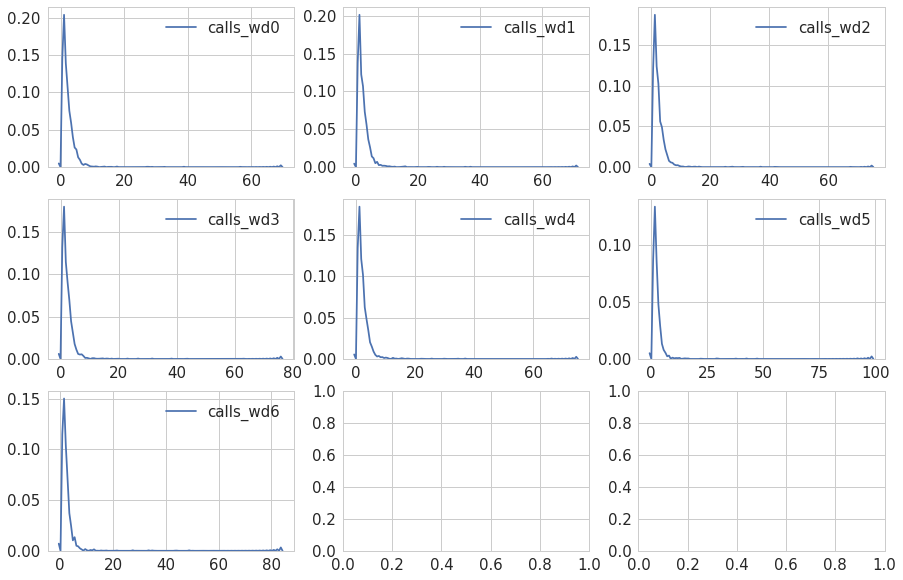

In [77]:
fig, ax_list = plt.subplots(3, 3, figsize=(15, 10))

n = 0
for i in range(3):
    for j in range(3):
        sns.kdeplot(calls_train['calls_wd{}'.format(n)], ax=ax_list[i][j]);
        n += 1
        if n > 6:
            break

Уже по графику видно, что распределение ассимметрично. Можно формально проверить на нормальность и ожидаемо отвергнуть гипотезу о нормальности. 

In [78]:
from scipy.stats import normaltest

alpha = 0.05
_, pvalue = normaltest(calls_train['calls_wd0'])
pvalue > alpha

False

__По будням/выходным__

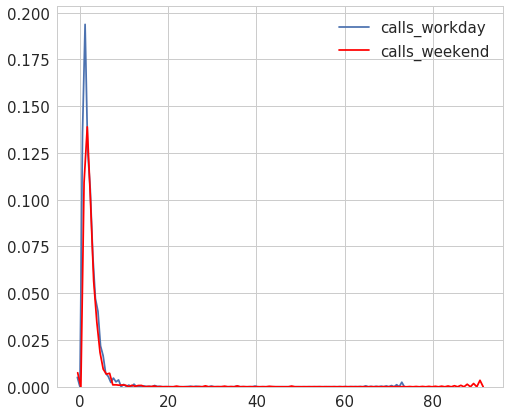

In [79]:
sns.kdeplot(calls_train['calls_workday'])
sns.kdeplot(calls_train['calls_weekend'], color='red');

__В среднем по всем дням__

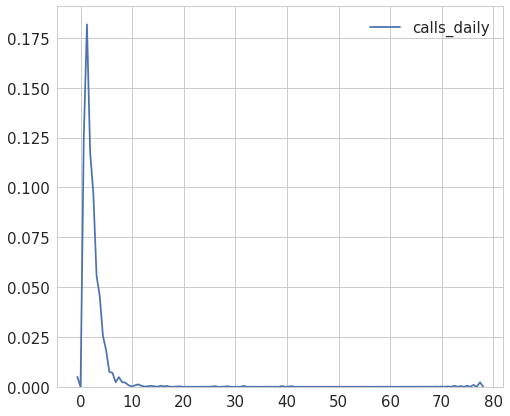

In [80]:
sns.kdeplot(calls_train['calls_daily']);

Главный вывод из графиков распределения: целевые признаки не распределены нормально, значения сильно группируются вблизи нуля. Возможно, стоит преобразовать целевой признак, чтобы избавиться от сильной ассимметричности.

__Посмотрим на boxplot звонков по дням недели__

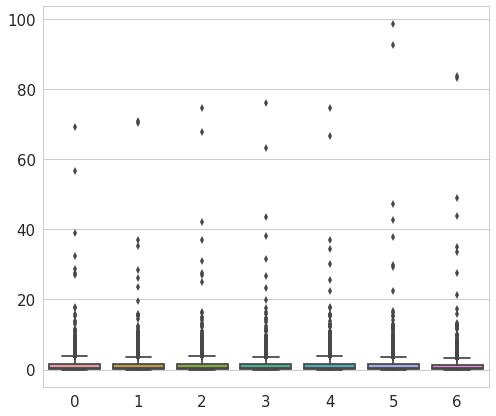

In [81]:
sns.boxplot(data=[calls_train['calls_wd{}'.format(i)] for i in range(7)]);

Здесь хорошо видны выбросы: по всем дням недели есть зоны, у которых число звонков заходит сильно выше верхнего квартиля. 

__Посмотрим поближе__

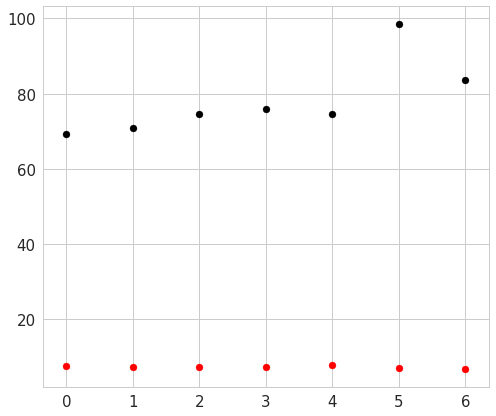

In [82]:
quant_99 = [calls_train['calls_wd{}'.format(i)].quantile(0.99) for i in range(7)]
mx = [calls_train['calls_wd{}'.format(i)].max() for i in range(7)]
plt.scatter(x=range(7), y=quant_99, c='red')
plt.scatter(x=range(7), y=mx, c='black');

__И на boxplot звонков по будням/выходным__

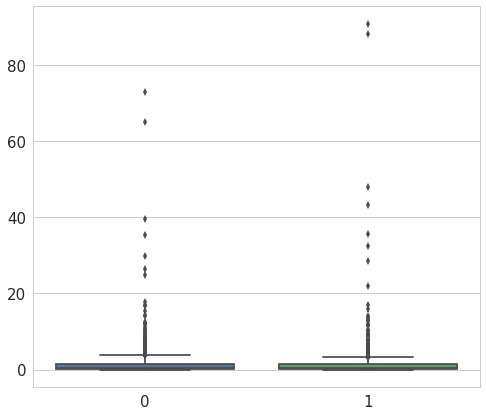

In [83]:
sns.boxplot(data=[calls_train.calls_workday, calls_train.calls_weekend]);

Из этих графиков можно сделать вывод о том, что есть участки, у которых среднее число вызовов нехарактерно большое. Причем, скорее всего, дело не в самих участках, а в каком-то ЧП, которое там произошло. Пожар, например, из-за которого могло резко увеличиться число звонков. Думаю, что при использовании линейной регрессии такие участки нужно исключить из выборки из-за нетипичности.

Еще можно посмотреть на эти участки на карте. Они не локализуются, то есть если это все-таки ЧП, то разные ЧП. 

In [84]:
quant_99 = calls_train['calls_daily'].quantile(0.99)
mask = calls_train['calls_daily'] > quant_99

In [85]:
many_calls_zones = zones_df.loc[idx_train][mask]

In [86]:
#начальным положением зададим Красную площадь
fmap = folium.Map([55.753722, 37.620657])

for _, row in many_calls_zones.iterrows():
    folium.CircleMarker([row.lat_c, row.lon_c], radius=4, color='#DC143C').add_to(fmap)
    
fmap    

__Попробуем посмореть, как коррелируют между собой признаки и как они влияют на целевой__

__Для dist_features__

tagged_points будут коррелировать со всеми, так что посмотрим на корреляцию признаков вида "число объектов в заданном радиусе" без tagged_points:

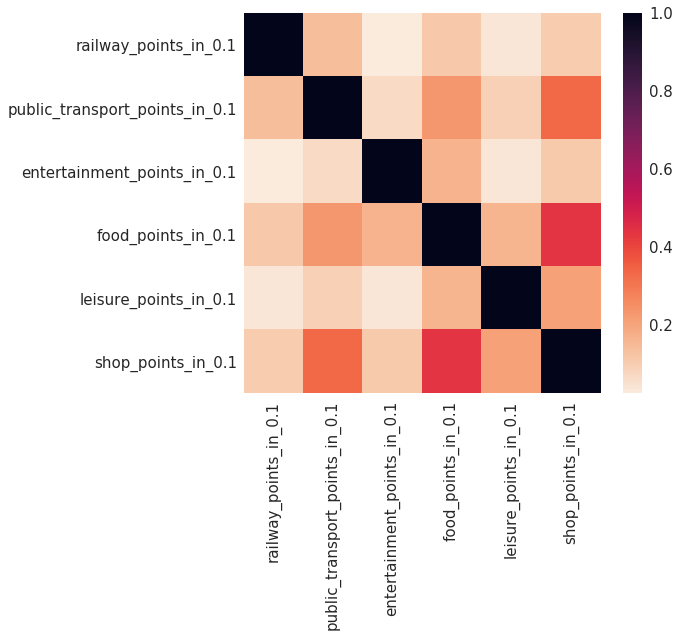

In [87]:
p_list = ['railway', 'public_transport', 'entertainment', 'food', 'leisure', 'shop']

cmap = sns.cm.rocket_r
sns.heatmap(dist_features.loc[idx_full, ['{}_points_in_0.1'.format(p) for p in p_list]]
            .corr('kendall'), cmap=cmap);

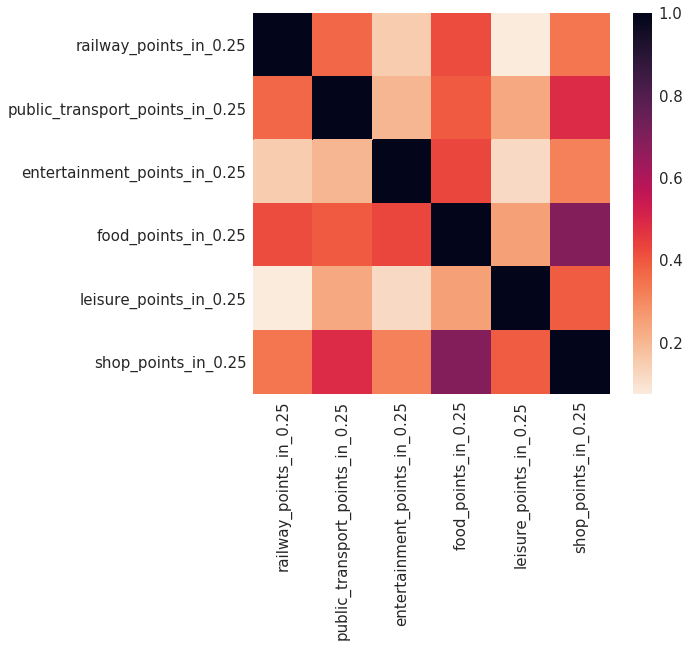

In [88]:
sns.heatmap(dist_features.loc[idx_full, ['{}_points_in_0.25'.format(p) for p in p_list]]
            .corr(), cmap=cmap);

Тут никаких полезных инсайтов, только бытовые наблюдения: коррелирует транспорт (в городе вокзалы часто рядом с метро и автобусными остановками), самые сильные корреляции — c магазинами (если в участке много магазинов, то там, скорее всего, есть большой торговый центр, в котором есть фуд-корты и которые стоят недалеко от остановок/метро). Возьмем побольше признаков.

__Для dist_features, house_features и base_stations__

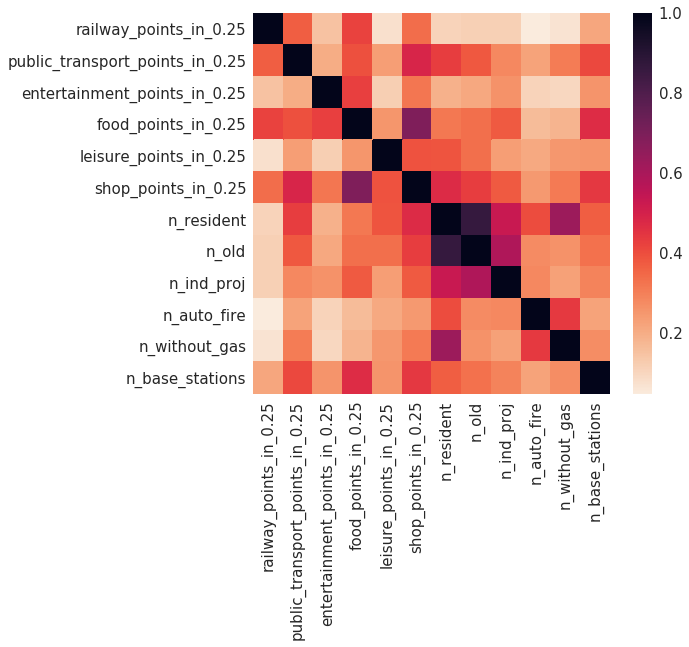

In [89]:
sns.heatmap(full_features.loc[idx_full, ['{}_points_in_0.25'.format(p) for p in p_list] +
                                        ['n_resident', 'n_old', 'n_ind_proj', 'n_auto_fire', 'n_without_gas'] +
                                        ['n_base_stations']]
            .corr(), cmap=cmap);

Число жилых домов сильно коррелирует с числом домов старше 1970 года и домов без газоснабжения. Из интересного вижу разве что корреляцию между числом базовых станций и магазинами и местами, где можно поесть: это, возможно, опять можно объяснить торговыми центрами.

__Посмотрим на влияние признаков на целевой__

Поскольку распределение звонков по дням недели слабо отличается, посмотрим на звонки не по дням недели, а по будням/выходным и в среднем по всем дням.

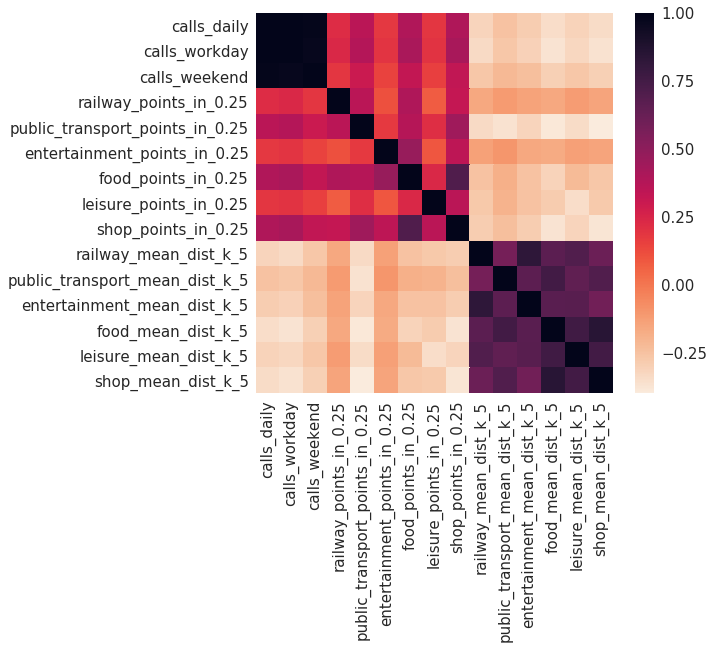

In [90]:
sns.heatmap(pd.concat([calls_train[['calls_daily', 'calls_workday', 'calls_weekend']],
                       train_features.loc[:, ['{}_points_in_0.25'.format(p) for p in p_list] +
                                             ['{}_mean_dist_k_5'.format(p) for p in p_list]] 
                      ],
                       axis=1)
                       .corr(), cmap=cmap);

Здесь звонки сильнее всего коррелируют с объектами, относящимися к общественному транспорту, с магазинами и кафе/ресторанами, причем положительно, хотя было предположение, что в случае с магазинами должно быть наоборот. Возможное объяснение: в торговых центрах могут быть пожары, при которых звонят сразу много людей (об этом выше), а рядом с остановками — аварии.

При этом со средним расстоянием до разных объектов звонки коррелируют слабо, то есть либо связь сильно нелинейная, либо связь в принципе слабая. Ниже посмотрим на графики; возможно, эти признаки можно будет вообще убрать.

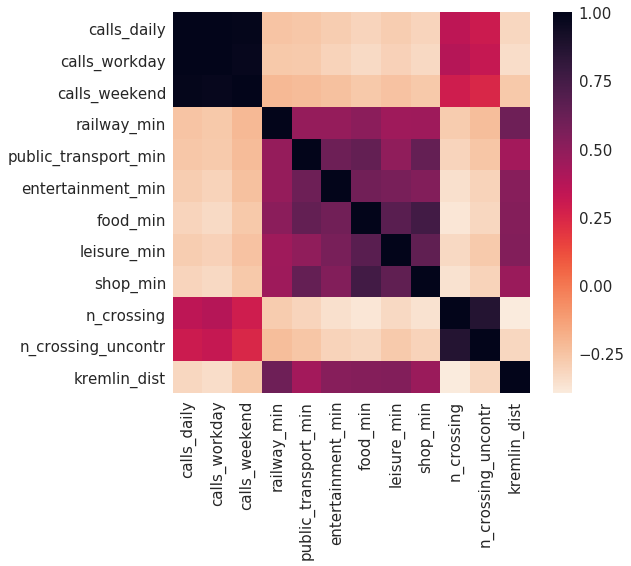

In [91]:
sns.heatmap(pd.concat([calls_train[['calls_daily', 'calls_workday', 'calls_weekend']],
                       train_features.loc[:, ['{}_min'.format(p) for p in p_list] +
                                             ['n_crossing'] +
                                             ['n_crossing_uncontr'] +
                                             ['kremlin_dist']]
                      ],
                       axis=1)
                       .corr(), cmap=cmap);

Сильнее всего звонки коррелируют с числом переходов. С минимальным расстоянием до объектов, включая Кремль, по силе корреляция меньше.

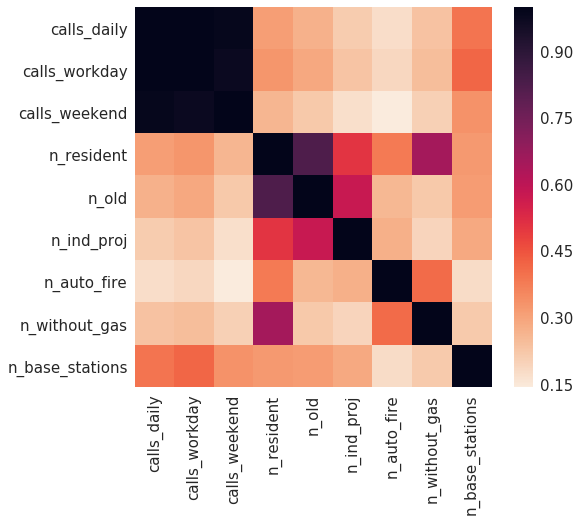

In [92]:
sns.heatmap(pd.concat([calls_train[['calls_daily', 'calls_workday', 'calls_weekend']],
                       train_features.loc[:, ['n_resident', 'n_old', 'n_ind_proj',
                                              'n_auto_fire', 'n_without_gas', 'n_base_stations']]
                      ],
                       axis=1)
                       .corr(), cmap=cmap);

Сильнее всего звонки коррелируют с числом БС. А вот с домами довольно слабо.

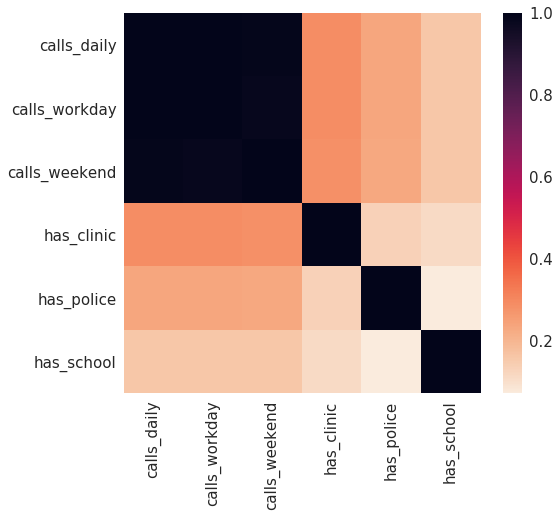

In [93]:
sns.heatmap(pd.concat([calls_train[['calls_daily', 'calls_workday', 'calls_weekend']],
                       train_features.loc[:, ['has_clinic', 'has_police', 'has_school']]
                      ],
                      axis=1)
                      .corr(method='spearman'), cmap=cmap);

Есть слабая корреляция звонков с числом больниц.

__Посмотрим на графики зависимости__ среднего числа звонков в день от признаков, с которыми имеется наиболее сильная корреляция.

__Влияние числа объектов в радиусе 250 м__:

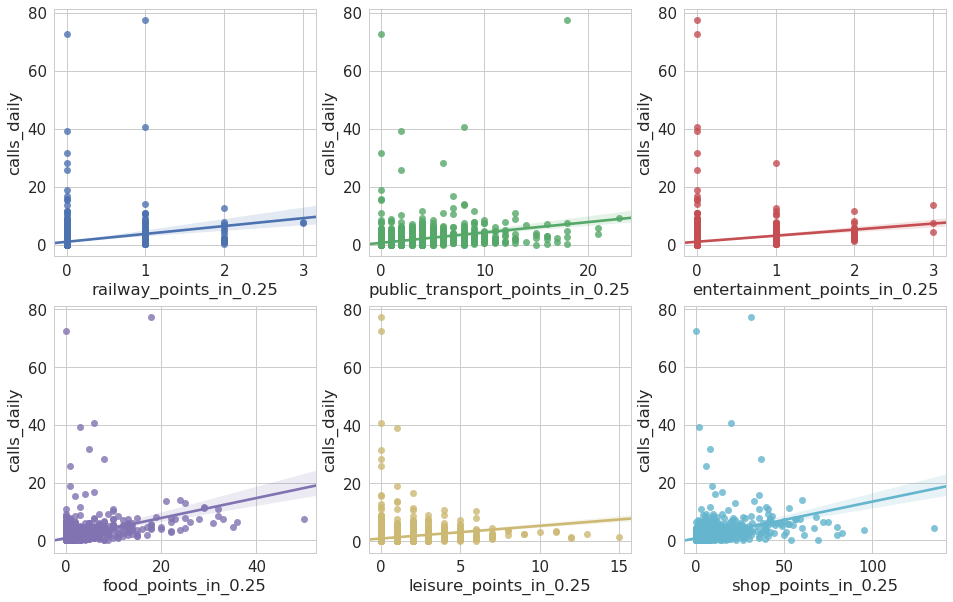

In [94]:
fig, ax_list = plt.subplots(2, 3, figsize=(16, 10))

ax_num = 0
for p in p_list:
    sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
                x='{}_points_in_0.25'.format(p), 
                y='calls_daily',
                ax=ax_list.reshape(-1, 1)[ax_num][0]);
    ax_num += 1

Что-то похожее на тренд, если не учитывать явные выбросы, видится разве что для shop_points и food_points. У остальных признаков виден сильный разброс относительно регрессионной прямой, которую строит Seaborn.

__Влияние числа переходов, БС и жилых домов__:

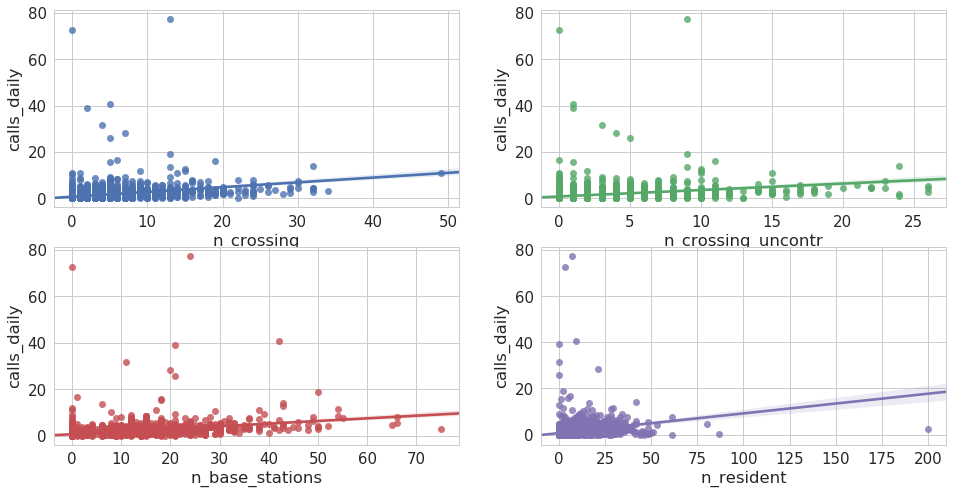

In [95]:
fig, ax_list = plt.subplots(2, 2, figsize=(16, 8))

sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_crossing', 
            y='calls_daily',
            ax=ax_list[0][0]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_crossing_uncontr', 
            y='calls_daily',
            ax=ax_list[0][1]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_base_stations', 
            y='calls_daily',
            ax=ax_list[1][0]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_resident', 
            y='calls_daily',
            ax=ax_list[1][1]);

У n_crossing и n_crossing_uncontr разброс относительно прямой и не видно особого тренда, как и у n_resident. Более плотно точки находятся около прямой для n_base_stations, если не учитывать выбросы.  

__Посмотрим на несколько графиков зависимости__ среднего числа звонков от признаков, с которыми слабая корреляция.

__Влияние минимального расстояния до объектов:__

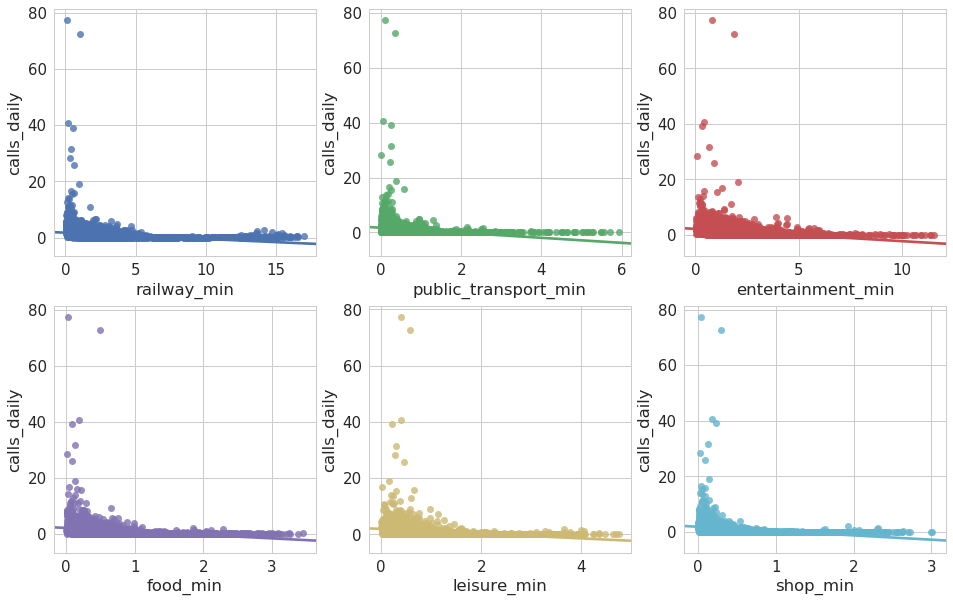

In [96]:
fig, ax_list = plt.subplots(2, 3, figsize=(16, 10))

ax_num = 0
for p in p_list:
    sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
                x='{}_min'.format(p), 
                y='calls_daily',
                ax=ax_list.reshape(-1, 1)[ax_num][0]);
    ax_num += 1

Признаки выглядят неинформативными, связи на графиках не видно. 

__Влияние среднего расстояния до объектов:__

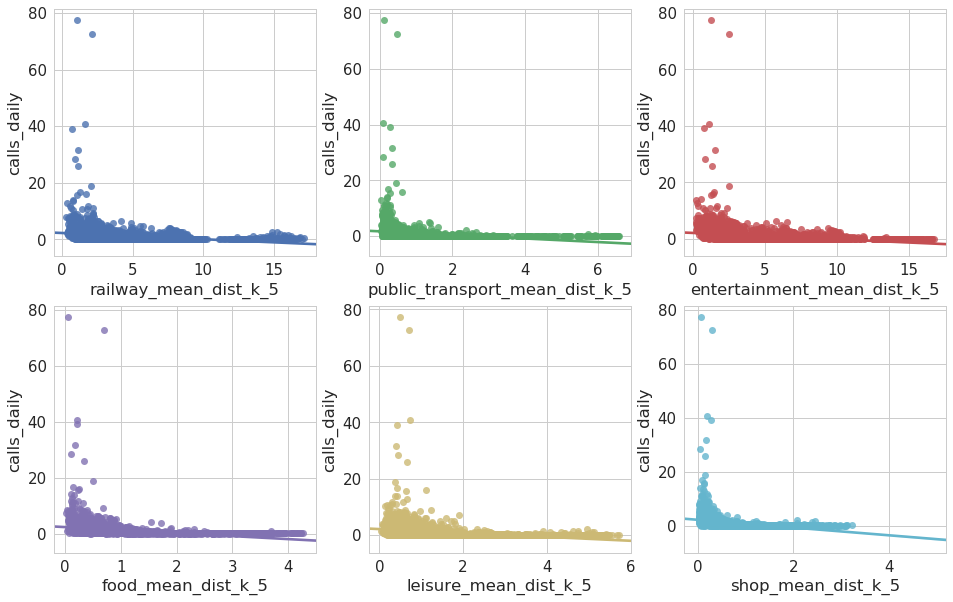

In [97]:
fig, ax_list = plt.subplots(2, 3, figsize=(16, 10))

ax_num = 0
for p in p_list:
    sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
                x='{}_mean_dist_k_5'.format(p), 
                y='calls_daily',
                ax=ax_list.reshape(-1, 1)[ax_num][0]);
    ax_num += 1

__Влияние числа объектов из full_house_info:__

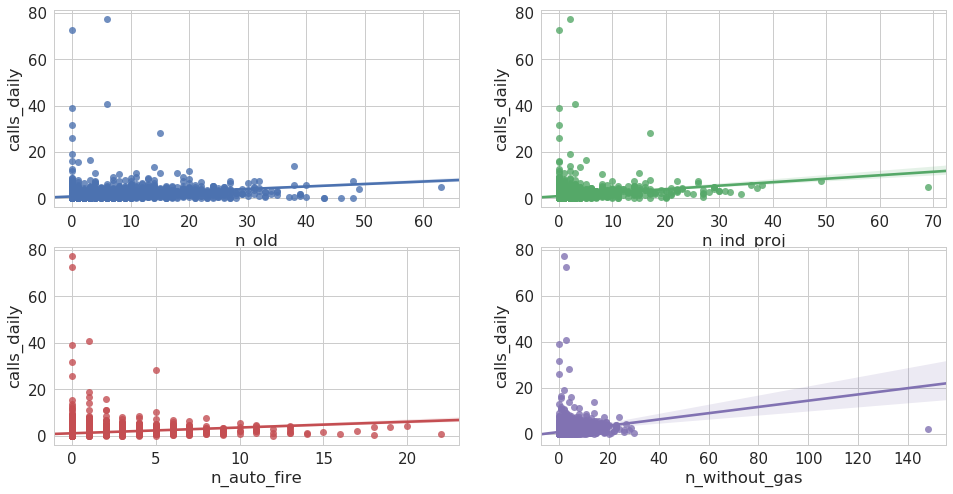

In [98]:
fig, ax_list = plt.subplots(2, 2, figsize=(16, 8))

sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_old', 
            y='calls_daily',
            ax=ax_list[0][0]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_ind_proj', 
            y='calls_daily',
            ax=ax_list[0][1]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_auto_fire', 
            y='calls_daily',
            ax=ax_list[1][0]);
sns.regplot(data=pd.concat([train_features, calls_train], axis=1),
            x='n_without_gas', 
            y='calls_daily',
            ax=ax_list[1][1]);

Стоит как минимум оставить n_ind_proj. 

__Еще одно наблюдение__

Посмотрим на то, как выглядит график зависимости звонков от одного из "хороших" признаков, например, от числа магазинов в радиусе 250 м, если из звонков выбросить аномальные примеры:

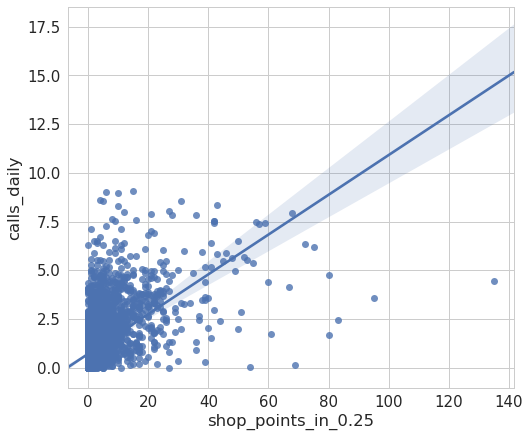

In [99]:
sns.regplot(data=pd.concat([train_features,
                            calls_train[calls_train.calls_daily < calls_train.calls_daily.quantile(0.995)]], axis=1),
                            x='shop_points_in_0.25', 
                            y='calls_daily');

И вот здесь становится грустно, потому что основная масса неаномальных точек просто кластеризуется в левом нижнем углу, а оставшиеся точки разбросаны относительно построенной прямой и никакого линейного тренда, да и в принципе тренда, не выделяется. 

Еще пример. Здесь вроде как можно увидеть тренд (по крайней мере, с ростом числа БС растет минимальное число звонков), но все еще с разбросом:

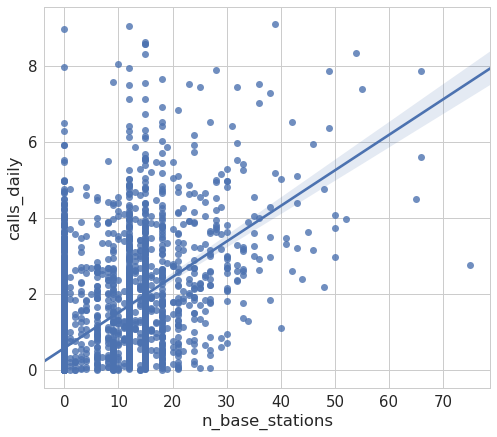

In [100]:
sns.regplot(data=pd.concat([train_features,
                            calls_train[calls_train.calls_daily < calls_train.calls_daily.quantile(0.995)]], axis=1),
                            x='n_base_stations', 
                            y='calls_daily');

__Выводы по анализу:__

1) Видны выбросы в числе звонков, что может объясняться крупными, но редкими ЧП. Если использовать линейную модель, то их, думаю, не стоит брать.  

2) Про возможные причины корреляций и зависимостей — в промежуточных выводах выше. Субъективно выделяются менее информативные признаки, которые можно проверить на lasso-регрессии, если все-таки использовать в качестве модели регрессию, и отбросить, если их веса занулятся. Либо вообще не трогать при использовании случайного леса, например: возможно, из них можно вытащить что-то полезное, если по-честному смотреть на критерий информативности, а не просто глазами на матрицу корреляций и графики. 

3) Среди относительно информативных признаков нет чудо-признаков, которые бы хорошо в одиночку объясняли целевую переменную. В лучшем случае можно выделить что-то похожее на зависимось и проверить, как самые информативные признаки будут работать вместе. Это влияет на дальнейший ход задачи: если бы было больше времени, наверное, стоило бы потратить часть его на более серьезный data mining, чем у меня: например, погулять по соцсетям и поанализировать посты с геотегами. 

## Создание признаков II <a name="feat_2"></a>

[К началу](#cont)

При анализе целевого признака были видны выбросы: области с аномально большим числом звонков. __Введем бинарный признак__  "есть ли по соседству участок с большим числом звонков". "По соседству" пусть означает, что расстояние между центрами участков не больше 550 м (если рассматривать участки как идеальные квадраты ровно 500х500 м, то расстояние было бы 500 м, еще 50 м накинем сверху из-за возможной неточности). 

Мотивация: с одной стороны, стоит выкинуть аномальные участки, чтобы не портить модель, чувствительную к выбросам. С другой, хочется как-то сохранить часть информации с этих участков. И даже если нетипичные участки не выкидывать, этот признак, возможно, поможет отделить часть участков не с аномально высоким, но с повышенным числом звонков, основываясь на соседстве с этими нетипичными участками. 

In [101]:
def many_calls_neighbour(zone_centre, many_calls_zones=many_calls_zones):
    '''
    in: array zone_centre (координаты центра участка lat_c, lon_c)
    out: 1, если участок рядом с участком с высоким числом звонков, 0 иначе
    '''
    for many_calls_zone in many_calls_zones[['lat_c', 'lon_c']].values:
        if distance(zone_centre, many_calls_zone) <= 0.55:
            return 1
    return 0    

In [102]:
mcn = zones_df[(zones_df.is_target == 1) | (zones_df.is_test == 1)]. \
      apply(lambda row: many_calls_neighbour(np.array([row.lat_c, row.lon_c])), axis=1)

In [103]:
train_features['mcn'] = mcn[idx_train]
test_features['mcn'] = mcn[idx_test]

## Выбор моделей и метрики <a name="model"></a>

[К началу](#cont)

Для оценки предсказаний используется тау Кендалла, и в задаче правильное упорядочивание важнее, чем точные численные ответы. Есть предположение о том, что похожие участки со схожими условиями проживания будут иметь похожее число звонков, а непохожесть наоборот позволит сравнивать число звонков в терминах меньше/больше — поэтому попробуем использовать метод ближайших соседей. Еще попробуем применить случайный лес из тех же соображений: лес сможет разбить объекты выборки на группы со схожими параметрами и схожим числом звонков, при этом обе эти модели смогут смоделировать нелинейную связь между признаками и числом звонков. А в конце посмотрим на то, как заработает градиентный бустинг. 

Метрика качества будет, понятно, тау Кендалла, раз она используется при оценке предсказаний.

Так как предсказания по дням недели оцениваются независимо, будем пока в качестве целевого признака брать среднее число звонков по всем дням (calls_daily). То есть получится, что для каждого участка предсказанное число звонков с понедельника по воскресенье будет одинаковым. 

## Предобработка данных и обучение <a name="learning"></a>

### KNeighborsRegressor <a name="knr"></a>

[К началу](#cont)

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import validation_curve, learning_curve, KFold
from sklearn.pipeline import Pipeline

В признаках вида prt_* много NaN (больше половины), заменять их средним/медианным значением или 0 будет слишком неинформативно, поэтому их в качестве признаков брать не будем. Бинарные признаки, слабо коррелирующие с целевой переменной, тоже попробуем не использовать.

Метод ближайших соседей чувствителен к масштабированию, так что используем StandardScaler. Участки с аномально большим числом звонков тоже пока выбросим. От большой размерности признакового пространства KNN может пострадать, так что используем PCA.

__Построим кривую валидации и подберем параметр n_neighbors__

In [105]:
def kendalltau_scorer(estimator, X, y):
    '''
    Возвращает коэффициент корреляции Кендалла;
    такой формат используется для совместимости с validation_curve и learning_curve
    '''
    from scipy.stats import kendalltau
    return kendalltau(estimator.predict(X), y).correlation

Подбирать будем только один гиперпараметр модели: число ближайших соседей, по которым путем усреднения числа звонков число звонков будет предсказываться для нового объекта. Подбирать будем на кросс-валидации (пятикратной, потому что данных не слишком много; с перемешиванием, раз временных меток у данных нет и сохранять временную структуру не надо; с помощью простого перебора). 

In [106]:
%%time
drop_cols = ['prt_old', 'prt_ind_proj', 'prt_without_gas', 'prt_auto_fire',
             'prt_crossing', 'has_clinic', 'has_school', 'has_police']
knr_params = range(1, 61)
knr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, random_state=27)),
                     ('knr', KNeighborsRegressor())])

train_score, test_score = validation_curve(knr_pipe, 
                                           train_features.drop(drop_cols, axis=1).drop(many_calls_zones.index),
                                           calls_train['calls_daily'].drop(many_calls_zones.index),
                                           'knr__n_neighbors', knr_params,
                                           cv=KFold(n_splits=5, shuffle=True, random_state=27), 
                                           scoring=kendalltau_scorer)

CPU times: user 7min 17s, sys: 16.7 s, total: 7min 34s
Wall time: 3min 35s


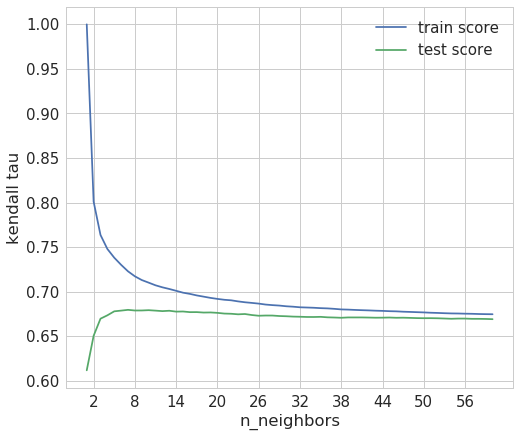

In [107]:
plt.plot(knr_params, train_score.mean(axis=1), label='train score')
plt.plot(knr_params, test_score.mean(axis=1), label='test score');
plt.xlabel('n_neighbors')
plt.xticks(np.arange(2, 61, 6))
plt.ylabel('kendall tau')
plt.legend();

В районе n_neighbors=8 у среднего скора на тесте максимум, кривая для теста близко к кривой для трейна, значит, можно предположить, что модель не переобучилась. Возьмем n_neighbors, отвечающий за максимальный средний тестовый скор.

In [108]:
n_neighbors = knr_params[np.argmax(test_score.mean(axis=1))]
n_neighbors

7

И посмотрим на максимальный средний тестовый скор.

In [109]:
test_score.mean(axis=1).max()

0.6795579289006037

__Построим кривую обучения с выбранным n_neighbors__

In [110]:
%%time
train_sizes=np.linspace(0.02, 1, 20)
knr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, random_state=27)),
                     ('knr', KNeighborsRegressor(n_neighbors=n_neighbors))])
N_train, train_score, test_score = learning_curve(knr_pipe, 
                                         train_features.drop(drop_cols, axis=1).drop(many_calls_zones.index),
                                         calls_train['calls_daily'].drop(many_calls_zones.index),
                                         train_sizes=train_sizes,
                                         cv=KFold(n_splits=5, shuffle=True, random_state=27), 
                                         scoring=kendalltau_scorer)

CPU times: user 1min 9s, sys: 3.22 s, total: 1min 12s
Wall time: 26.9 s


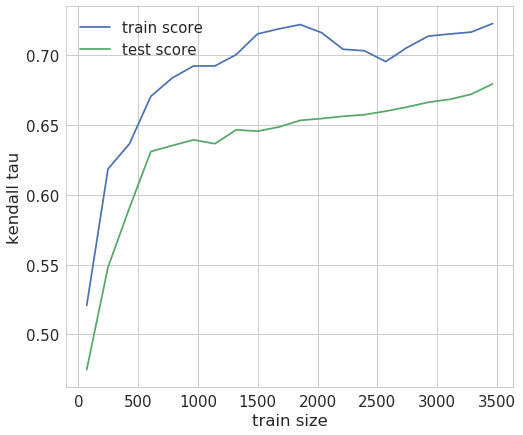

In [111]:
plt.plot(N_train, train_score.mean(axis=1), label='train score')
plt.plot(N_train, test_score.mean(axis=1), label='test score');
plt.xlabel('train size')
plt.ylabel('kendall tau')
plt.legend();

Кривые для трейна и теста еще не сошлись, у обоих видна тенденция на рост с увеличением размера выборки. 

Попробуем __сделать предсказания этой модели на тесте и обучить еще одну__ на всех данных из обучающей выборки (до этого использовались только целевые участки). Признаков, соответственно, станет меньше, потому что некоторые получать долго и дорого и они считались только для целевых участков.  

In [112]:
def write_submission_file(y_pred, filename, idx_test=idx_test):
    
    '''
    Записывает предсказанные результаты в файл;
    y_pred -- предсказания для числа звонков в среднем по всем дням
    '''
    from collections import OrderedDict
    
    calls = ['calls_wd{0}'.format(i) for i in range(0, 7)]
    pred_df = pd.DataFrame(OrderedDict([(col_name, y_pred) for col_name in calls]), index=idx_test)
    pred_df.to_csv(filename)

__Масштабирование, PCA__

В пайплайне выше масштабировался и бинарный признак mcn, потому что не хотелось с этим возиться, здесь же его масштабировать не будем. 

In [113]:
scaler = StandardScaler()

drop_cols = ['prt_old', 'prt_ind_proj', 'prt_without_gas', 'prt_auto_fire',
             'prt_crossing', 'has_clinic', 'has_school', 'has_police', 'mcn']

scaler.fit(train_features.drop(drop_cols, axis=1).drop(many_calls_zones.index))
train_features_scaled = np.concatenate([scaler.transform(train_features.drop(drop_cols, axis=1).drop(many_calls_zones.index)), 
                                       train_features['mcn'].drop(many_calls_zones.index).values.reshape(-1, 1)], axis=1)
test_features_scaled = np.concatenate([scaler.transform(test_features.drop(drop_cols, axis=1)), 
                                       test_features['mcn'].values.reshape(-1, 1)], axis=1)    

pca = PCA(n_components=0.95, random_state=27)

pca.fit(train_features_scaled)
train_features_pca = pca.transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

__Обучение с лучшим гиперпараметром, предсказание для теста__

In [114]:
knr = KNeighborsRegressor(n_neighbors=n_neighbors)

knr.fit(train_features_pca, calls_train['calls_daily'].drop(many_calls_zones.index))
calls_pred = knr.predict(test_features_pca)
write_submission_file(calls_pred, 'knr.csv')

__Результат на LB__

34 место из 63 на тот момент.

<img src="https://habrastorage.org/webt/tx/ye/1o/txye1o9annxuglvpxoh-goa6u_i.png" />

### KNeighborsRegressor на расширенной выборке <a name="knr_ext"></a>

[К началу](#cont)

__Дополним два признака и создадим новые выборки__

In [115]:
%%time
n_base_stations_non_target = zones_df[zones_df.is_target == 0] \
                            .apply(lambda row: obj_count((row.lat_bl, row.lon_bl, row.lat_tr, row.lon_tr),
                                                stat_coords), axis=1)

CPU times: user 2min 14s, sys: 8 ms, total: 2min 14s
Wall time: 2min 14s


In [116]:
n_base_stations_ext = pd.concat([n_base_stations, n_base_stations_non_target]).sort_index()

In [117]:
idx_train_ext = zones_df[zones_df.is_test == 0].index
calls_train_ext = zones_df.loc[idx_train_ext, :].iloc[:, 8:]

quant_99 = calls_train_ext['calls_daily'].quantile(0.99)
mask = calls_train_ext['calls_daily'] > quant_99

many_calls_zones_ext = zones_df.loc[idx_train][mask]

/home/panda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [118]:
%%time
mcn_non_target = zones_df[zones_df.is_target == 0]. \
                 apply(lambda row: many_calls_neighbour(np.array([row.lat_c, row.lon_c]),
                                                        many_calls_zones=many_calls_zones_ext), axis=1)

CPU times: user 7.76 s, sys: 120 ms, total: 7.88 s
Wall time: 7.53 s


In [119]:
mcn_ext = pd.concat([mcn, mcn_non_target]).sort_index()

In [120]:
full_features_ext = pd.concat([dist_features,
                               crossing_features,
                               n_base_stations_ext.rename('n_base_stations'),
                               mcn_ext.rename('mcn')],
                               axis=1)

In [121]:
train_features_ext = full_features_ext.loc[idx_train_ext]
test_features_ext = full_features_ext.loc[idx_test]

__Посмотрим на кривую валидации__

In [122]:
%%time
knr_params = range(1, 21)
knr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, random_state=27)),
                     ('knr', KNeighborsRegressor())])

train_score, test_score = validation_curve(knr_pipe, 
                                           train_features_ext.drop('prt_crossing', axis=1).drop(many_calls_zones_ext.index),
                                           calls_train_ext['calls_daily'].drop(many_calls_zones_ext.index),
                                           'knr__n_neighbors', knr_params,
                                           cv=KFold(n_splits=5, shuffle=True, random_state=27), 
                                           scoring=kendalltau_scorer)

CPU times: user 9min 38s, sys: 10 s, total: 9min 48s
Wall time: 7min 59s


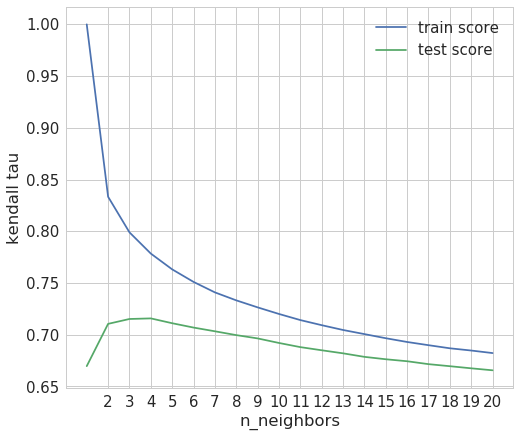

In [123]:
plt.plot(knr_params, train_score.mean(axis=1), label='train score')
plt.plot(knr_params, test_score.mean(axis=1), label='test score');
plt.xlabel('n_neighbors')
plt.xticks(np.arange(2, 21))
plt.ylabel('kendall tau')
plt.legend();

Кривые не сходятся, как в прошлый раз, но не сильно отличаются.

In [124]:
n_neighbors = knr_params[np.argmax(test_score.mean(axis=1))]
n_neighbors

4

In [125]:
test_score.mean(axis=1).max()

0.7157553940140844

__Масштабирование, PCA__

In [126]:
scaler = StandardScaler()

scaler.fit(train_features_ext.drop('prt_crossing', axis=1).drop(many_calls_zones_ext.index))
train_features_ext_scaled = np.concatenate([scaler.transform(train_features_ext.drop('prt_crossing', axis=1).drop(many_calls_zones_ext.index)), 
                            train_features_ext['mcn'].drop(many_calls_zones_ext.index).values.reshape(-1, 1)], axis=1)
test_features_ext_scaled = np.concatenate([scaler.transform(test_features_ext.drop('prt_crossing', axis=1)), 
                           test_features_ext['mcn'].values.reshape(-1, 1)], axis=1)    

pca = PCA(n_components=0.95, random_state=27)

pca.fit(train_features_ext_scaled)
train_features_ext_pca = pca.transform(train_features_ext_scaled)
test_features_ext_pca = pca.transform(test_features_ext_scaled)

__Обучение с лучшим гиперпараметром, предсказание для теста__

In [127]:
knr = KNeighborsRegressor(n_neighbors=n_neighbors)

knr.fit(train_features_ext_pca, calls_train_ext['calls_daily'].drop(many_calls_zones_ext.index))
calls_pred = knr.predict(test_features_ext_pca)
write_submission_file(calls_pred, 'knr_extended.csv')

__Результаты на LB__

Все здорово просело. По всей видимости, учитывать нецелевые участки все-таки не стоит, либо стоит как-то по-хитрому, например, отсекая участки с совсем маленьким числом звонков и брать топ-n по звонкам. Если останется время, то можно попробовать и это. 

<img src="https://habrastorage.org/webt/id/6e/-u/id6e-urdmvodkr7_db8vxsfdjgq.png" />

### RandomForestRegressor <a name="rfr"></a>

[К началу](#cont)

Здесь строить кривые валидации и обучения уже не будем, просто посмотрим на cross_val_score, параметры у валидации те же. Гиперпараметры для леса тоже особо подбирать не будем и воспользуемся советами из [статьи курса](https://habrahabr.ru/company/ods/blog/324402/#2-sluchaynyy-les) насчет размера подмножества признаков и минимального числа объектов в листах. Деревьев попробуем взять 500 (лес не переобучается от количества деревьев, так что можно и больше).

От выбросов лес не пострадает, так что и участки с аномальным числом звонков выбрасывать не будем.

In [128]:
drop_cols = ['prt_old', 'prt_ind_proj', 'prt_without_gas', 'prt_auto_fire', 'prt_crossing']

In [129]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

n_features = train_features.drop(drop_cols, axis=1).shape[1]
rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, max_features=round(n_features / 3), random_state=27)
cvs = cross_val_score(estimator=rfr, X=train_features.drop(drop_cols, axis=1), y=calls_train['calls_daily'],
                      scoring=kendalltau_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=27))

CPU times: user 1min 58s, sys: 4 ms, total: 1min 58s
Wall time: 1min 58s


In [130]:
cvs

array([0.67895391, 0.6994678 , 0.70841713, 0.71949003, 0.68076624])

In [131]:
cvs.mean(), cvs.std()

(0.6974190204331986, 0.01568796346714987)

In [132]:
rfr.fit(train_features.drop(drop_cols, axis=1), calls_train['calls_daily'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=42, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=27,
           verbose=0, warm_start=False)

__Посмотрим на значимость признаков__

Некоторые новые признаки, которые создавались вручную не на основе StarterKit, оказались в топ-20: число зон-соседей с большим числом звонков, число жилых домов в участке, число БС в участке. Еще для леса оказались важными признаки вроде минимальное/максимальное расстояние до какого-то объекта, хотя предполагалось, что эти признаки заработают хуже, чем число каких-то объектов в участке. 

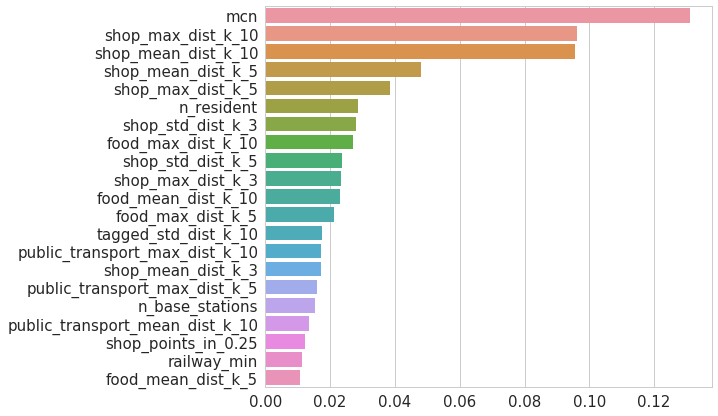

In [133]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(y=train_features.drop(drop_cols, axis=1).columns[indices[:21]],
            x=importances[indices[:21]],
            orient='h');

In [134]:
calls_pred = rfr.predict(test_features.drop(drop_cols, axis=1))
write_submission_file(calls_pred, 'rfr.csv')

__Результаты на LB__

14 место из 65 на тот момент.

<img src="https://habrastorage.org/webt/jk/-h/8u/jk-h8uembrj7xszlnhswynsjdbk.png" />

### XGBRegressor <a name="xgb"></a>

[К началу](#cont)

In [135]:
# !pip install xgboost

In [136]:
from xgboost.sklearn import XGBRegressor

В качестве базовых алгоритмов возьмем деревья. Настраивать гиперпараметры будем в два этапа: сначала для базовых алгоритмов (max_depth, максимальную глубину деревьев; colsample_bytree, долю признаков, на которой будет обучаться каждое дерево, и gamma,  минимальное уменьшение функции потерь, при котором вершина дерева еще будет разбиваться). 

max_depth и gamma напрямую контролируют сложность базовой модели, а colsample_bytree добавляет шума для большей устойчивости модели ([документация XGBoost](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html?highlight=parameters)). Интервалы перебора max_depth и colsample_bytree берутся навскидку, gamma с предварительной оценкой.

Потом настроим темп обучения и число деревьев в модели. Также оставим отложенную выборку и результаты обоих этапов настройки гиперпараметров оценим на ней.

__Оценим возможный интервал для gamma__

__Подберем первый блок параметров__

Решается задача регрессии, в качестве функции потерь будет по умолчанию использоваться RMSE. 

$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{({\hat{y_i} - y_i})^2}}$$ 

Поскольку предсказываются доли, то максимальной RMSE будет, когда всегда предсказывается число звонков, равное единице, когда на самом деле звонков всегда ноль. Тогда RMSE лежит в интервале от 0 до 1.

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_features.drop(drop_cols, axis=1),
                                                      calls_train['calls_daily'],
                                                      test_size=0.2,
                                                      random_state=27)

xgbr_params = {'max_depth': np.arange(3, 16, 3),
               'colsample_bytree': [0.3, 0.6, 0.9], 
               'gamma': np.append(np.logspace(-4, -1, 4), 0)}

cv = GridSearchCV(estimator=XGBRegressor(random_state=27), param_grid=xgbr_params, scoring=kendalltau_scorer,
                  cv=KFold(n_splits=5, shuffle=True, random_state=27), n_jobs=-1)

In [138]:
%%time
cv.fit(X_train, y_train)

CPU times: user 9.26 s, sys: 136 ms, total: 9.4 s
Wall time: 4min 43s


GridSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=27,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 3,  6,  9, 12, 15]), 'colsample_bytree': [0.3, 0.6, 0.9], 'gamma': array([0.0001, 0.001 , 0.01  , 0.1   , 0.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function kendalltau_scorer at 0x7fcc5cdae950>, verbose=0)

In [139]:
cv.best_params_, cv.best_score_

({'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 15}, 0.7044009052230397)

__Оценим на отложенной выборке__

In [140]:
kendalltau(cv.predict(X_valid), y_valid).correlation

0.6763752860411899

__Посмотрим на второй блок параметров__

Попробуем увеличить число деревьев и снизить темп обучения (по умолчанию 0.1), learning_rate, при этом увеличив число итераций, num_boost_round (по умолчанию 10). Будем использовать оптимальные параметры с кросс-валидации выше.

In [141]:
xgbr_params = {'n_estimators': [200, 300, 400, 500],
               'learning_rate': [0.01, 0.001]}
set_params = {'max_depth': 15, 
              'gamma': 0,
              'colsample_bytree': 0.6,
              'random_state': 27,
              'num_boost_round': 20}

cv = GridSearchCV(estimator=XGBRegressor(**set_params),
                  param_grid=xgbr_params, scoring=kendalltau_scorer,
                  cv=KFold(n_splits=5, shuffle=True, random_state=27), n_jobs=-1)

In [142]:
%%time
cv.fit(X_train, y_train)

CPU times: user 30.6 s, sys: 120 ms, total: 30.7 s
Wall time: 4min 10s


GridSearchCV(cv=KFold(n_splits=5, random_state=27, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_boost_round=20, objective='reg:linear',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400, 500], 'learning_rate': [0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=<function kendalltau_scorer at 0x7fcc5cdae950>, verbose=0)

In [143]:
cv.best_params_, cv.best_score_

({'learning_rate': 0.01, 'n_estimators': 500}, 0.7050324255576468)

__И оценим на отложенной выборке__

In [144]:
kendalltau(cv.predict(X_valid), y_valid).correlation

0.6819195815626021

__Обучим xgb на всей выборке и сделаем предсказания на тестовой__

In [145]:
final_params = {'max_depth': 15, 
                'gamma': 0,
                'colsample_bytree': 0.6,
                'random_state': 27,
                'num_boost_round': 20,
                'learning_rate': 0.01,
                'n_estimators': 500}
xgbr = XGBRegressor(**final_params)
xgbr.fit(train_features.drop(drop_cols, axis=1), calls_train['calls_daily'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, num_boost_round=20, objective='reg:linear',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [146]:
write_submission_file(xgbr.predict(test_features.drop(drop_cols, axis=1)), 'xgbr.csv')

__Результат на LB__

Хуже, чем у леса. Вероятно, стоит еще повозиться с гиперпараметрами, например, подбирать число итераций и параметры ранней остановки тоже на кросс-валидации. 

<img src="https://habrastorage.org/webt/kz/cz/af/kzczafhzo7irgs2rmc7_9lt4a_i.png" />

## Почти выводы <a name="alm_conc"></a>

[К началу](#cont)

Наткнулась на [публичный кернел](http://nbviewer.jupyter.org/github/VlasovKirill/mts-geohack/blob/master/2-public_ranking.ipynb) от Кирилла Власова и воспользовалась его идеей преобразовать целевой признак так, чтобы его распределение было менее ассимметричное и больше похоже на нормальное, что, в предположении, должно лучше сохранять порядок зон по числу звонков.

Преобразование — корень от логарифма (log1p) целевого признака. На графики, где видно, как изменяется целевой признак, можно посмотреть в кернеле. 

In [147]:
%%time

n_features = train_features.drop(drop_cols, axis=1).shape[1]
rfr = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, max_features=round(n_features / 3), random_state=27)
cvs = cross_val_score(estimator=rfr, X=train_features.drop(drop_cols, axis=1), y=np.sqrt(np.log1p(calls_train['calls_daily'])),
                      scoring=kendalltau_scorer, cv=KFold(n_splits=5, shuffle=True, random_state=27))

CPU times: user 1min 47s, sys: 92 ms, total: 1min 47s
Wall time: 1min 47s


In [148]:
cvs, cvs.mean(), cvs.std()

(array([0.69015234, 0.71074992, 0.72253939, 0.72753449, 0.69787759]),
 0.7097707460044103,
 0.01418362903467942)

In [149]:
rfr.fit(train_features.drop(drop_cols, axis=1), np.sqrt(np.log1p(calls_train['calls_daily'])))
calls_pred = rfr.predict(test_features.drop(drop_cols, axis=1))
calls_pred = np.expm1(calls_pred ** 2)
write_submission_file(calls_pred, 'rfr_calls_modelled.csv')

__Результаты на LB__

С лесом и преобразованием получилось 10 место из 71 на тот момент.

<img src="https://habrastorage.org/webt/fv/pc/as/fvpcasemde11qmwshqq9rddp1ly.png" />

__Текущий рейтинг__

Посылок больше, чем тех, которые выносились в этот проект: в проекте пропускались первые пробные посылки на основе стартера.

<img src="https://habrastorage.org/webt/k2/nt/rk/k2ntrklewoe82f9xhc8hlkkzme4.png" />

## Выводы <a name="conc"></a>

[К началу](#cont)

Если по-честному, то корреляция в 67% выглядит довольно маленькой и ненадежной, если решение всерьез применять на практике. Наверное, отчасти это объясняется сложностью моделируемого процесса, в котором много случайности, хотя есть и какие-то закономерности, которые модель улавливает. Думаю, чтобы решение действительно заработало, нужно побольше данных в обучающей выборке и больше информативных признаков. С признаками вообще получается одновременно и сложнее, и проще, чем в соревнованиях, где внешние данные не разрешены: проще, потому что можно брать вообще все, что одобрят организаторы, и сложнее, потому что нужно много времени тратить на обдумывание того, что нужно искать, сам поиск и предобработку. Зато интересно. 

Много чего можно улучшить в самом решении, конечно:

1) Использовать данные по ЧП (статистику пожаров и ДТП, например). Проблема: сходу такие данные в удобном формате не ищутся, много возни с обработкой. Плюс такие данные полезны для соревнования, но для реального применения на практике — не очень, потому что признаки на их основе были бы по сути построены на статистике из будущего.

2) Использовать данные из соцсетей и, возможно, часть нецелевых участков, об этом писала выше.

3) Использовать данные, которые хотелось использовать, если бы они нашлись: хотела построить признаки на основе данных по жилым домам с камерами видеонаблюдения во дворе/в подъезде, но нашла такие данные только для Москвы, но не для МО.

4) Использовать более сложные модели; получше настроить xgboost, который должен зайти в этой задаче, потому что признаков немного; либо вообще подойти к задаче не как к задаче регрессии ([вот здесь](http://nbviewer.jupyter.org/github/VlasovKirill/mts-geohack/blob/master/2-public_ranking.ipynb) Кирилл Власов подходит к задаче как к задаче ранжирования: соответственно, меняется функция потерь и можно более явно оптимизировать именно порядок, а не точные значения; я о таком подходе не думала.

5) Попробовать решать задачу как классификацию: кластеризовать участки из трейна по какому-то подмножеству информативных признаков, таким образом получить кластеры-классы.

6) Поработать с целевым признаком: например, отдельно предсказывать разные дни недели, учитывать рабочие/нерабочие дни.
